In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
from scipy.special import expit as logistic
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
az.style.use('arviz-doc')


In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

<center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Generalizando modelos lineales</h1>



<br>
<br>
<br>
<br>
<br>

## Objetivos

* Introducir el concepto de modelo lineal
* Explorar la flexibilidad de los modelos lineales

## Regresión polinomial

<br>

* Cuando nos referimos a que un modelo es lineal, nos referimos a que es lineal en los parámetros

$$\mu = \beta_0 x^0 + \beta_1 x^1  \dots + \beta_m x^m$$


* Si prestamos atención, podemos ver que este polinomio _esconde_  un modelo lineal simple. De hecho si hacemos que $\beta_n = 0$ para $n \gt 1$ obtendremos:

$$\mu = \beta_0 + \beta_1 x$$


* Probemos ajustar un conjunto de datos usando una regresión polinomial de grado 2.

$$\mu = \beta_0 + \beta_1 x + \beta_2 x^2$$

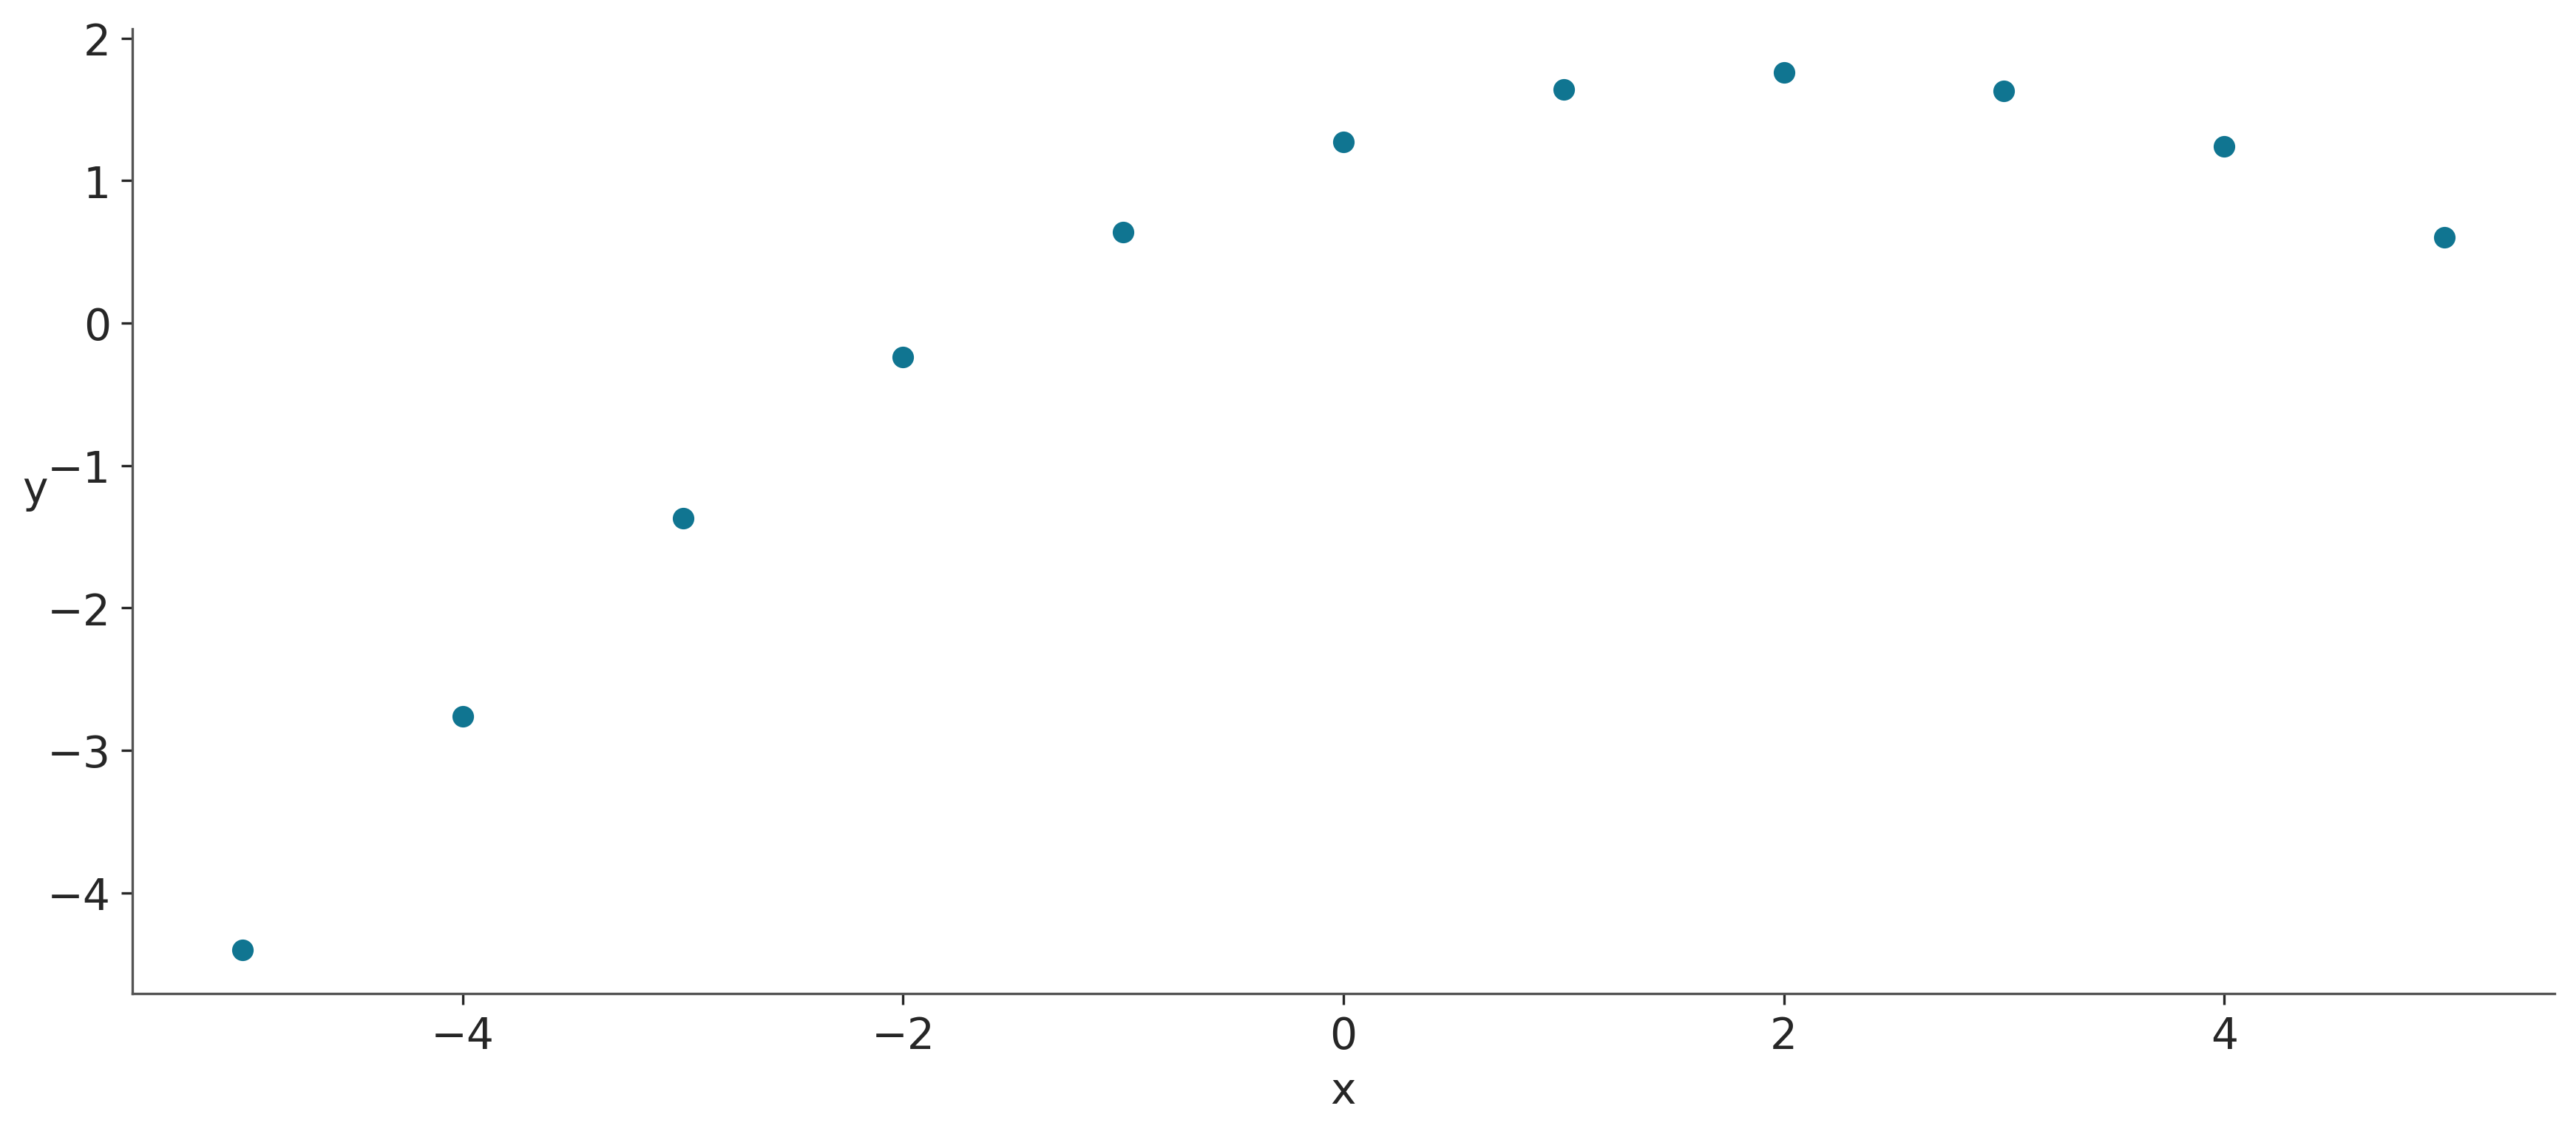

In [5]:
ans = pd.read_csv('../datos/anscombe.csv')
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()
y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0);

In [6]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_2.mean(), sigma=1)
    β1 = pm.Normal('β1', mu=0, sigma=1)
    β2 = pm.Normal('β2', mu=0, sigma=1)
    ϵ = pm.HalfNormal('ϵ', 10)

    mu = α + β1 * x_2 + β2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu=mu, sigma=ϵ, observed=y_2)
    
    idata_poly = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, ϵ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


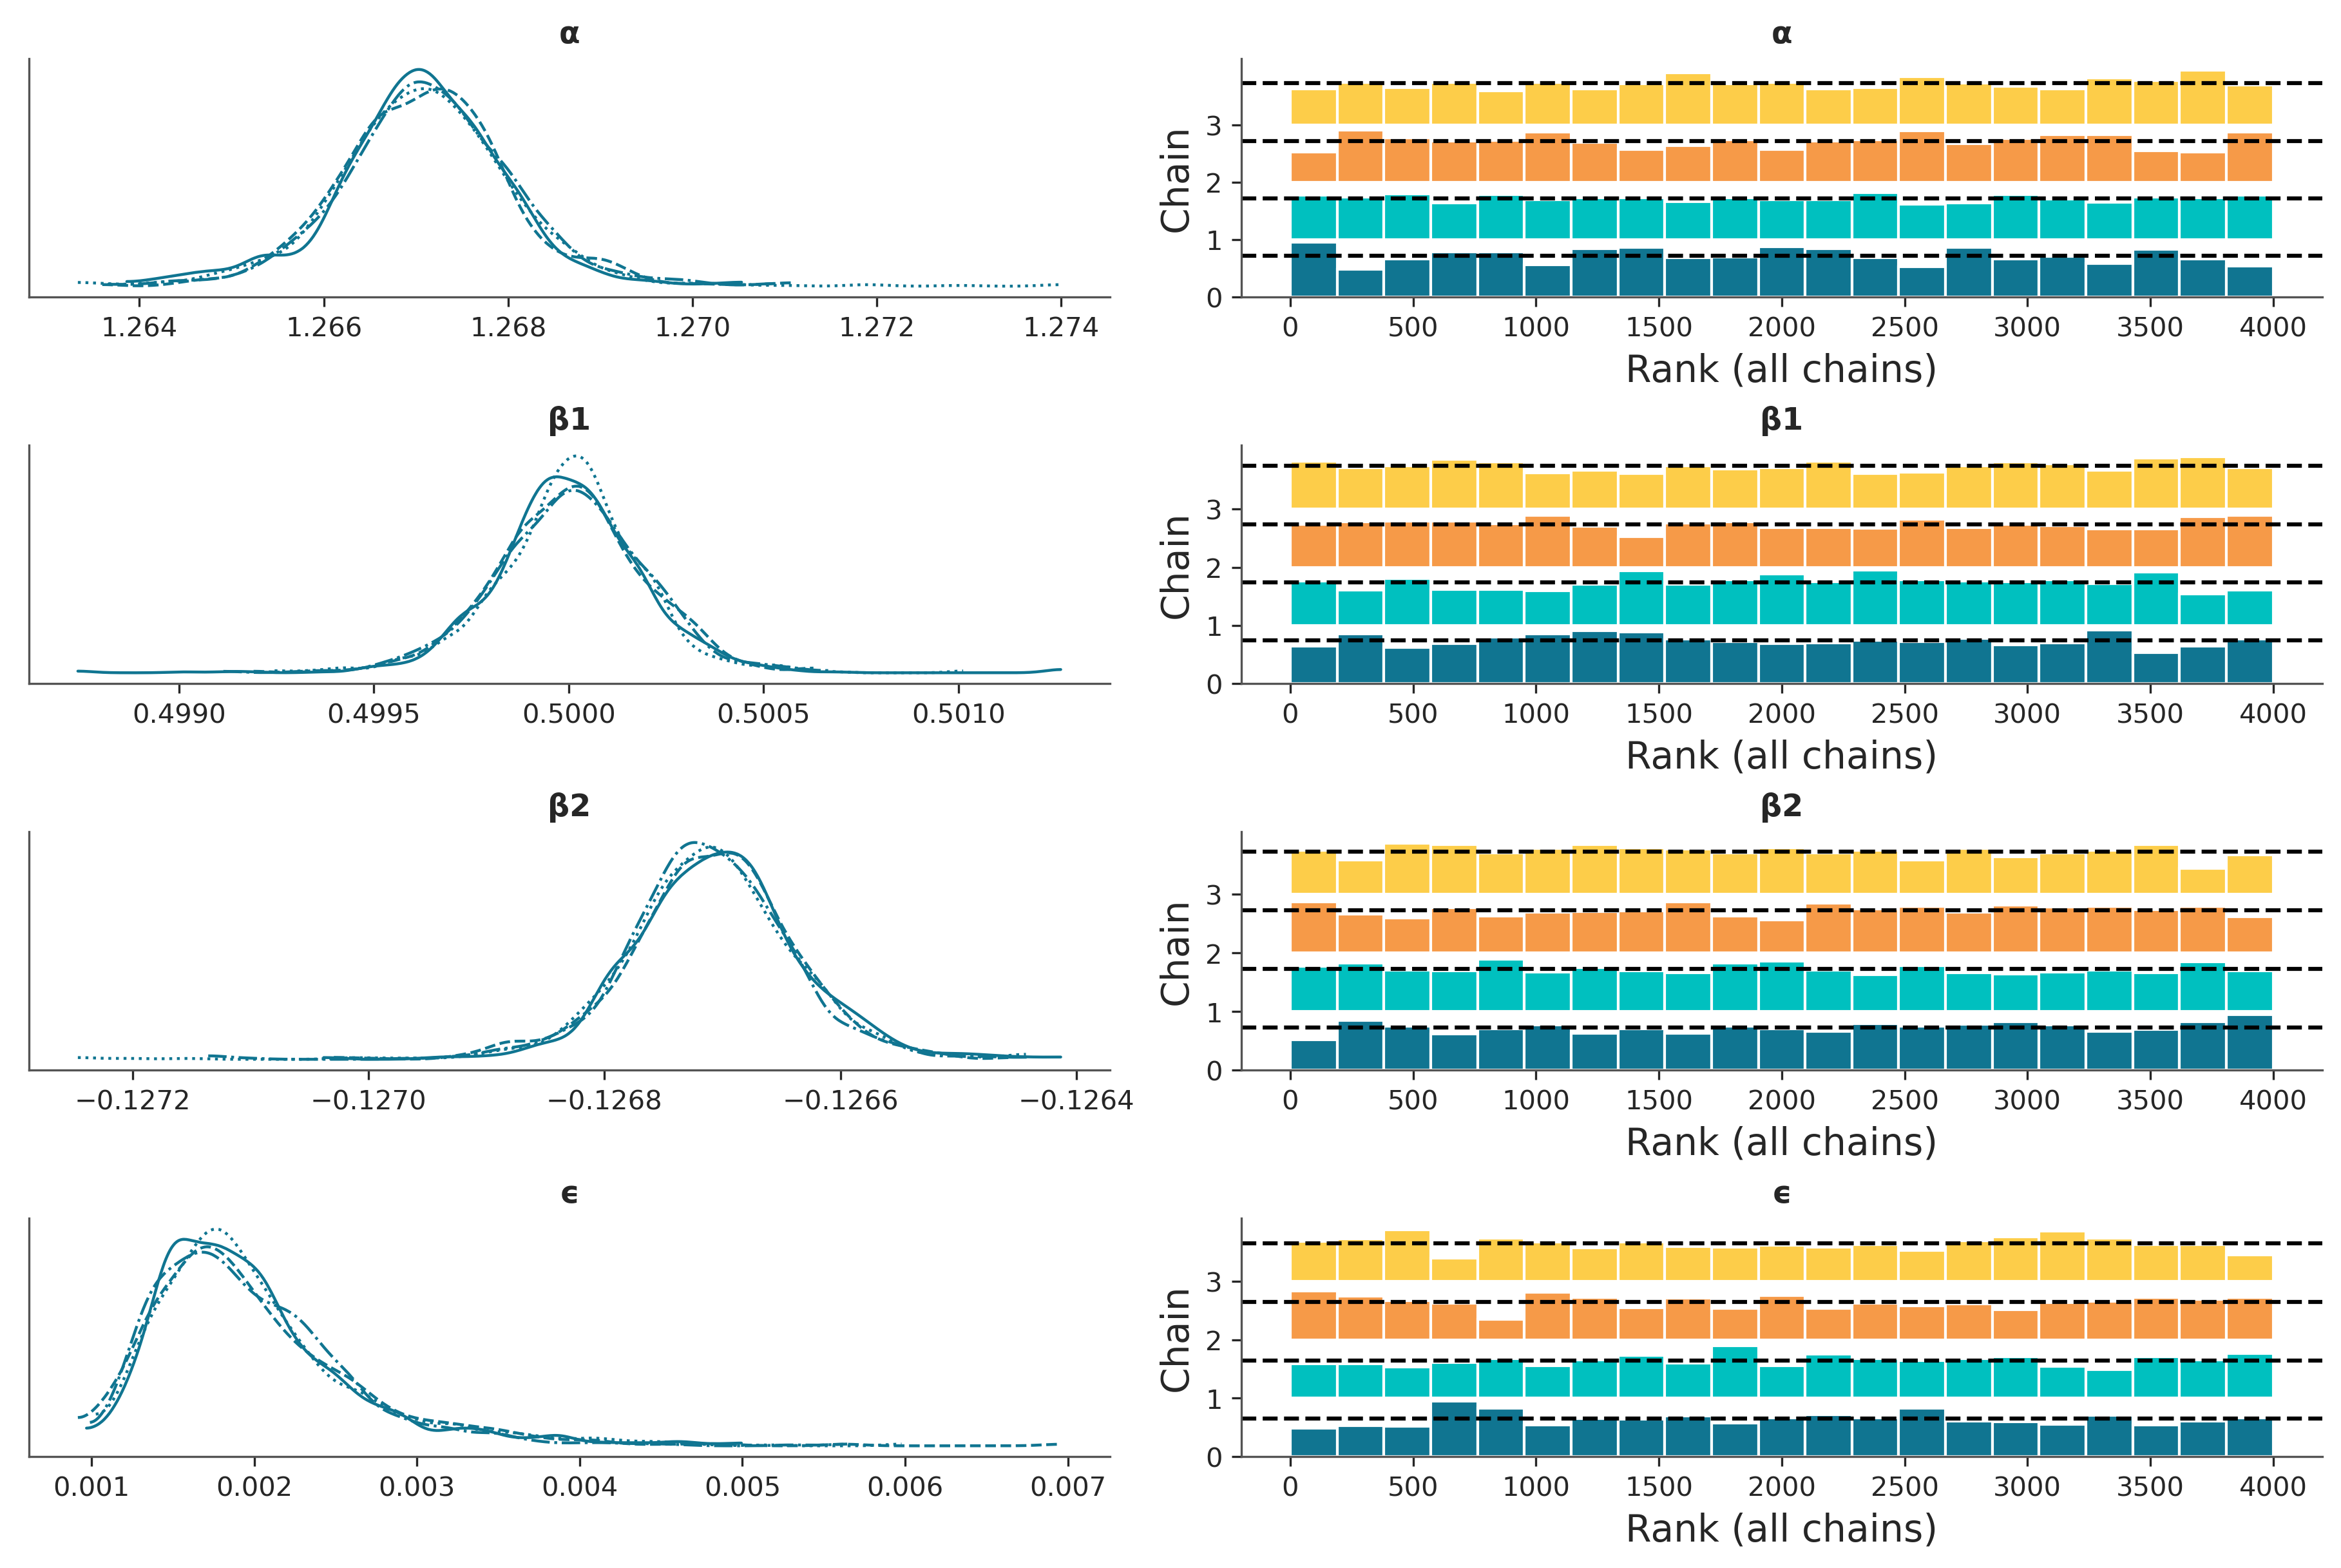

In [7]:
az.plot_trace(idata_poly, kind="rank_bars");

In [8]:
az.summary(idata_poly)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   1.267  0.001   1.265    1.269        0.0      0.0    2032.0    1696.0   
β1  0.500  0.000   0.500    0.500        0.0      0.0    2861.0    2432.0   
β2 -0.127  0.000  -0.127   -0.127        0.0      0.0    1888.0    1856.0   
ϵ   0.002  0.001   0.001    0.003        0.0      0.0    1860.0    1732.0   

    r_hat  
α     1.0  
β1    1.0  
β2    1.0  
ϵ     1.0

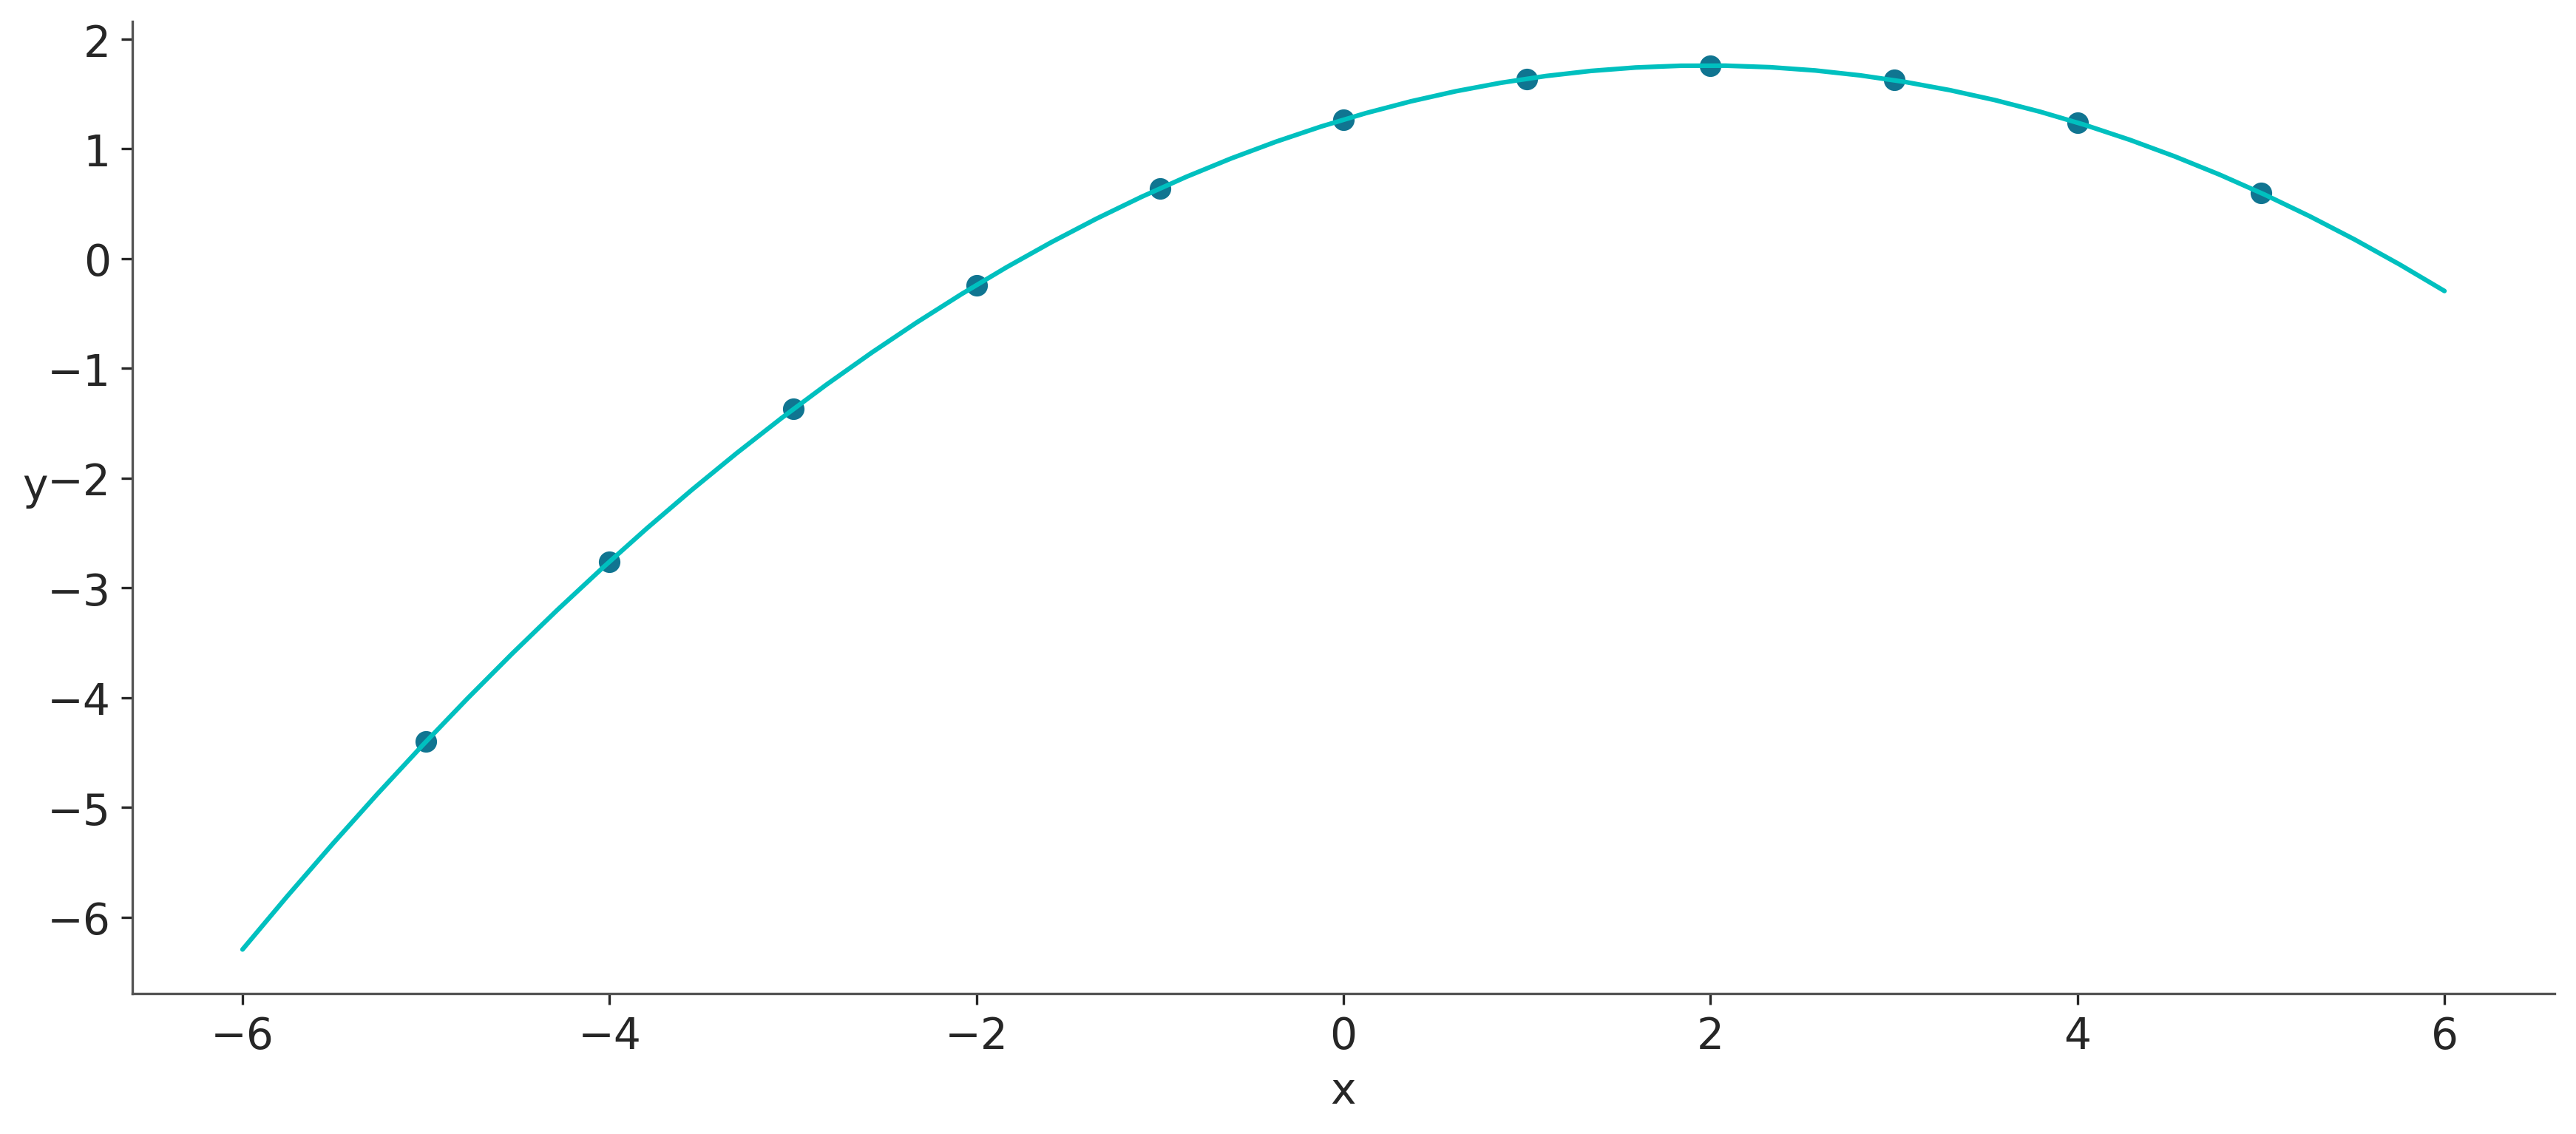

In [9]:
x_p = np.linspace(-6, 6)
post_mean = idata_poly.posterior.mean(("chain", "draw"))

y_p = post_mean['α'].item() + post_mean['β1'].item() * x_p + post_mean['β2'].item() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x',)
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1');

## Varianza variable y transformaciones

<br>

* Hemos estado usando el modelo lineal para modelar la media de una distribución, dejando la varianza de lado. 


* En caso que consideremos que el supuesto de varianza constante no tiene sentido, una posibilidad es considerar la varianza como una función (lineal) de la variable dependiente.



* La Organización Mundial de la Salud y otras instituciones de salud de todo el mundo recopilan datos para recién nacidos


* Un ejemplo son la longitud (alturas) de las niñas recién nacidas en función de la edad (en meses):

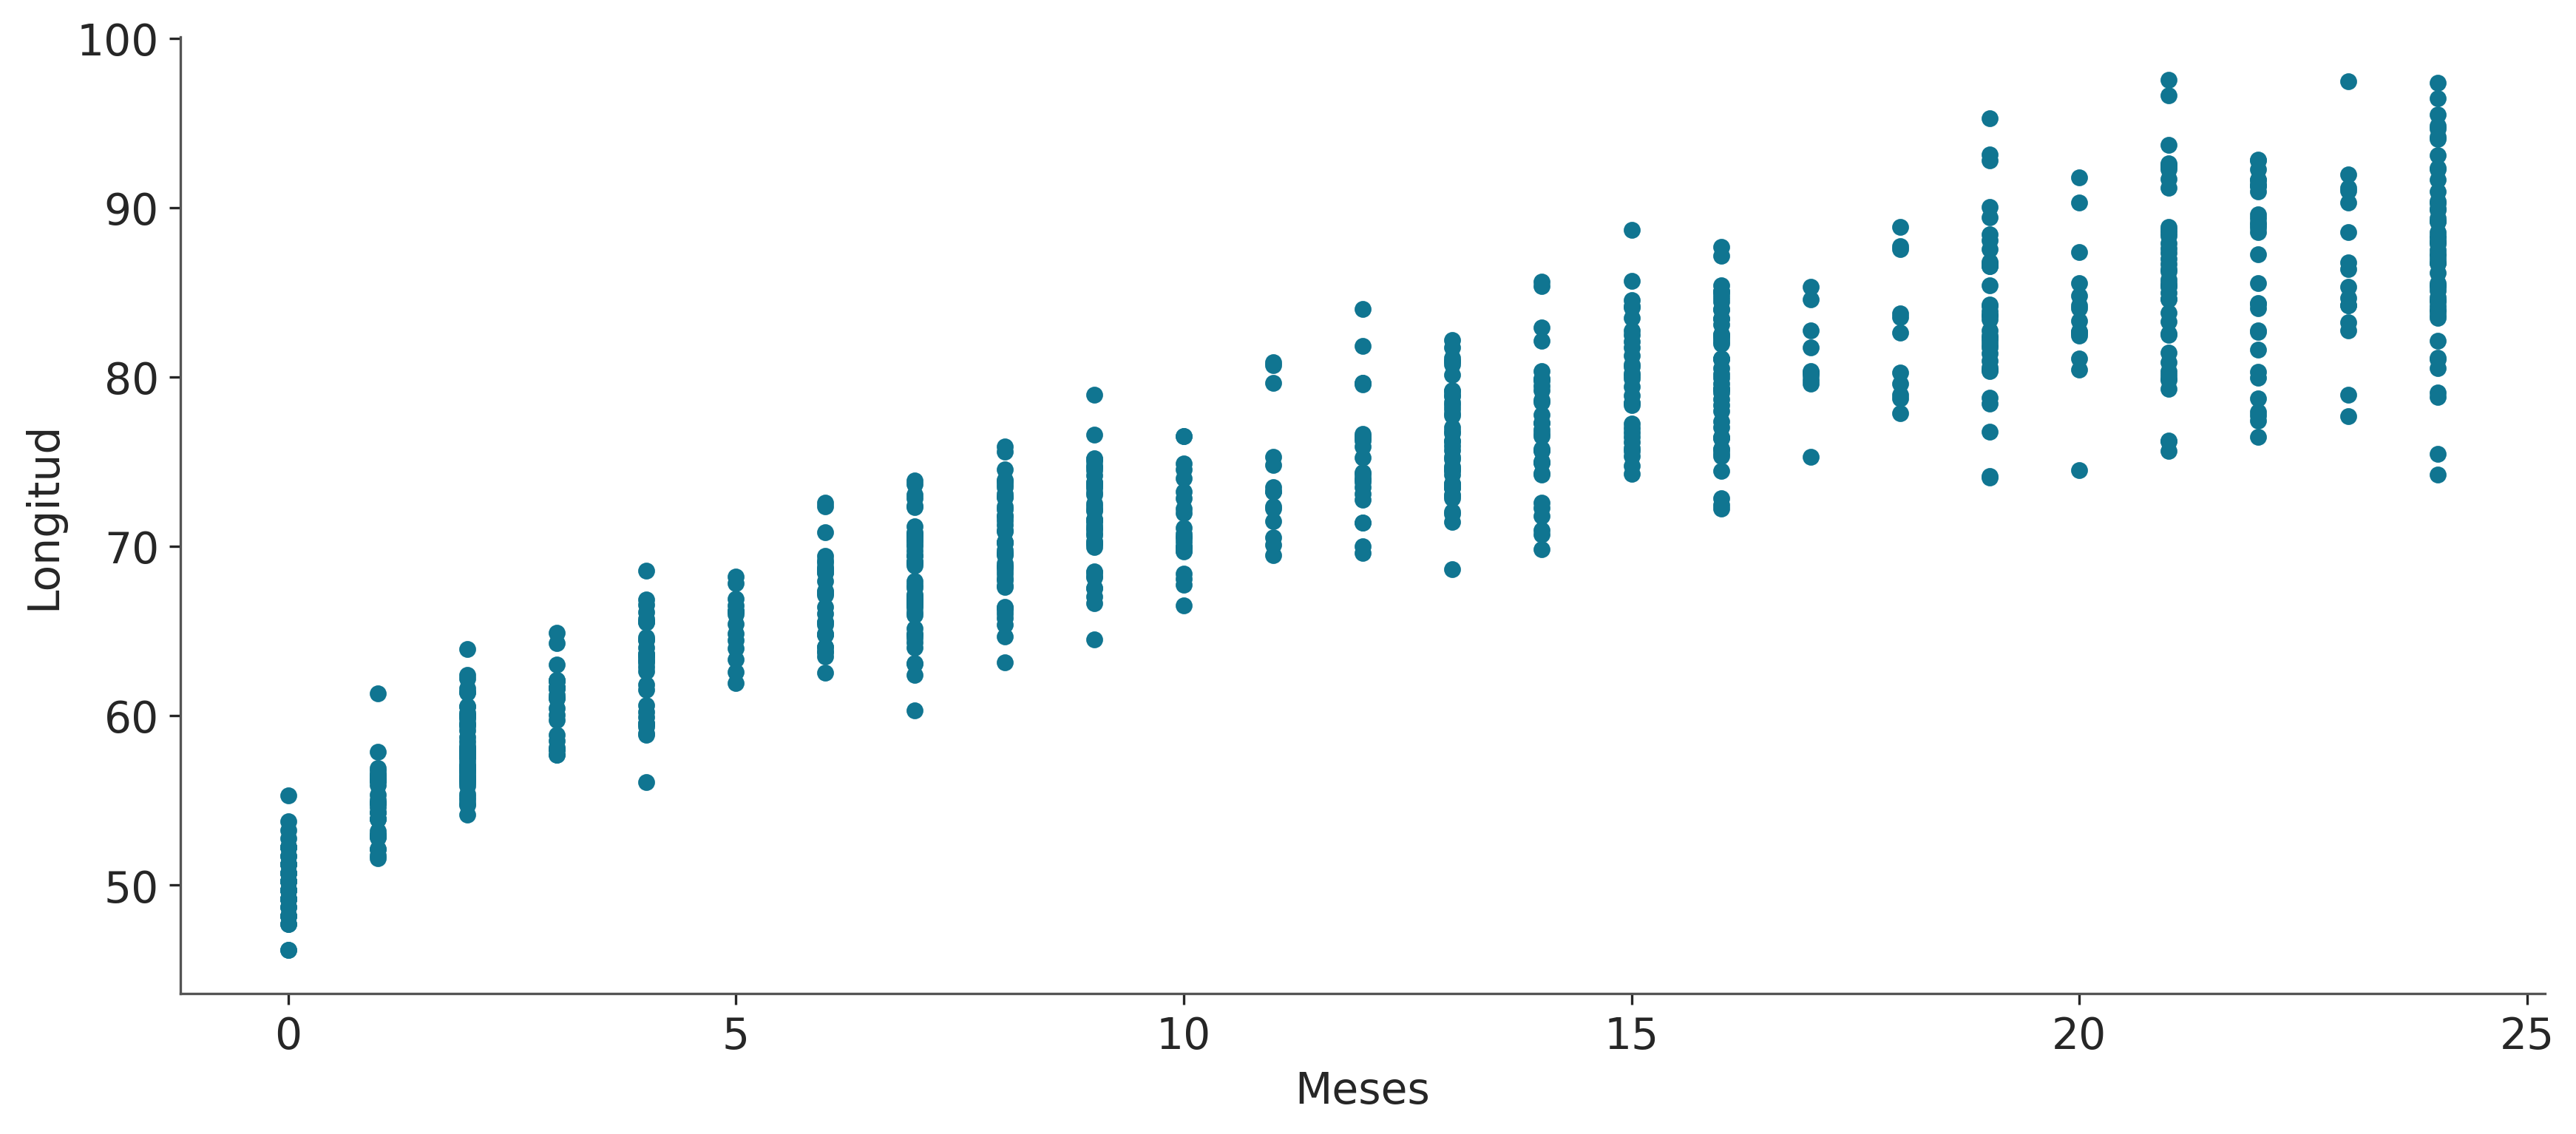

In [4]:
data = pd.read_csv('../datos/babies.csv')
data.plot.scatter('Meses', 'Longitud');

Para modelar estos datos, presentaremos 3 elementos nuevos en comparación con los modelos anteriores:

<br>


* $\epsilon$ ahora es una función lineal de $X$, y para hacer esto agregaremos dos nuevos parámetros $\gamma$ y $\delta$, estos son análogos directos de $\alpha$ y $\beta$.


* El modelo lineal para la media es una función de $\sqrt{X}$, esto es solo un _truco_ para ajustar una curva usando un modelo lineal


* Vamos a definir una variable "x_shared" usando la función `pm.MutableData()`. Esto nos permitirá cambiar los valores de la variable aleatoria `Meses` sin la necesidad de volver a correr el modelo. 

In [8]:
with pm.Model() as model_vv:
    x_shared = pm.MutableData("x_shared", data.Meses.values.astype(float))
    α = pm.Normal('α', sigma=10)
    β = pm.Normal('β', sigma=10)
    γ = pm.HalfNormal('γ', sigma=10)
    δ = pm.HalfNormal('δ', sigma=10)


    μ = pm.Deterministic('μ', α + β * x_shared**0.5)
    ϵ = pm.Deterministic('ϵ', γ + δ * x_shared)
    
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=data.Longitud)
    
    idata_vv = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, γ, δ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


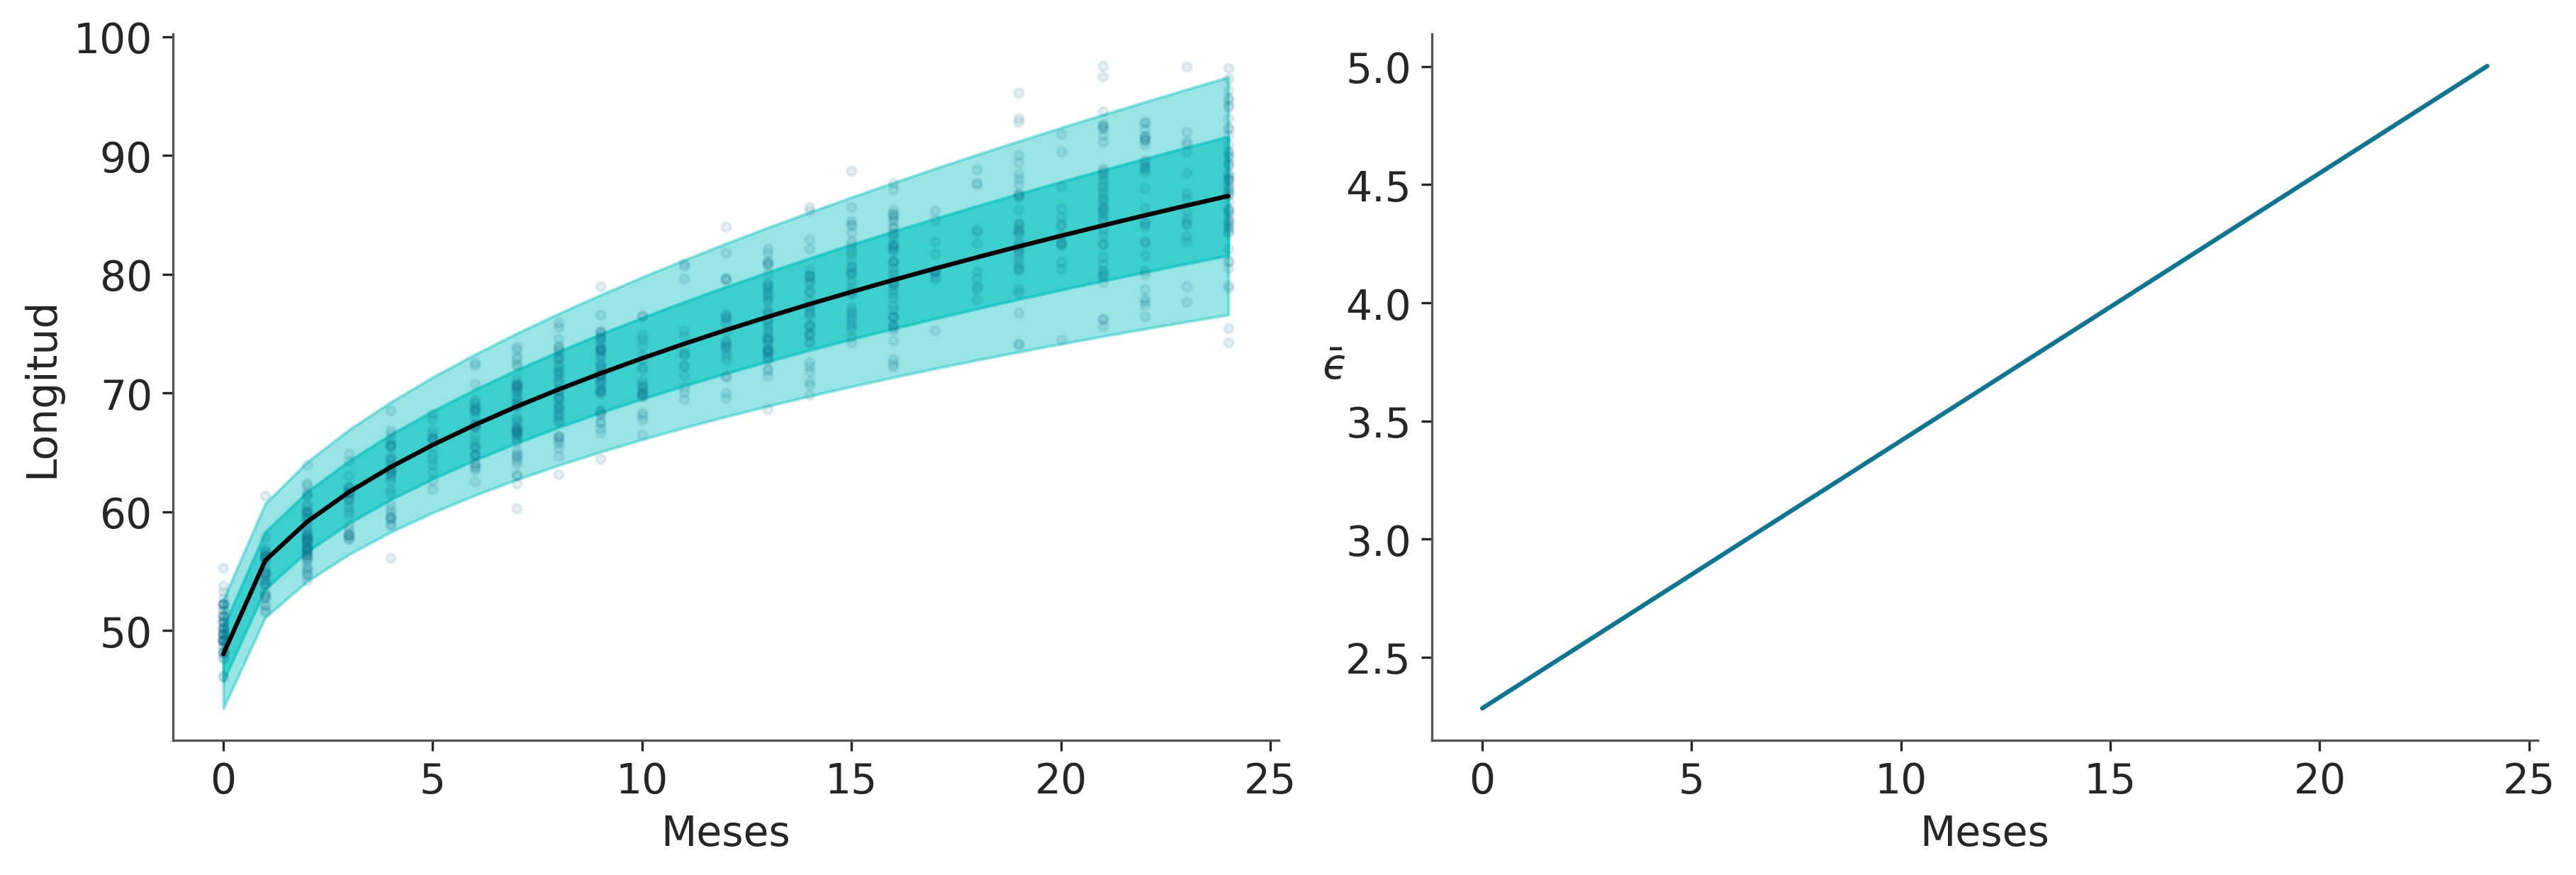

In [6]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(data.Meses, data.Longitud, 'C0.', alpha=0.1);

posterior = az.extract(idata_vv)

μ_m = posterior['μ'].mean("sample").values
ϵ_m = posterior['ϵ'].mean("sample").values

axes[0].plot(data.Meses, μ_m, c='k')
axes[0].fill_between(data.Meses, μ_m + 1 * ϵ_m, μ_m - 1 * ϵ_m, alpha=0.6, color='C1')
axes[0].fill_between(data.Meses, μ_m + 2 * ϵ_m, μ_m - 2 * ϵ_m, alpha=0.4, color='C1')

axes[0].set_xlabel('Meses')
axes[0].set_ylabel('Longitud');


axes[1].plot(data.Meses, ϵ_m)
axes[1].set_xlabel('Meses');
axes[1].set_ylabel(r'$\bar ϵ$', rotation=0);

* PyMC permite generar datos  $\tilde Y$ a partir del modelo ajustado usando la función `pm.sample_posterior_predictive()`.


* Por defecto, en una regresión, estas muestras $\tilde Y$ serán evaluadas para los valores observados de 'X' (predicciones dentro de la muestra o in sample predictions).


* Si queremos generar datos  $\tilde y$  para valores de $X$ no observados necesitamos actualizar el valor de la variable `x_shared` usando la función `pm.set_data()`, por esta razón es que en el modelo definimos a `x_shared` usando la función `pm.MutableData()`.

* Veamos cuales son los valores de $\tilde Y$ cuando $x=0.5$ (medio mes).

In [9]:
with model_vv:
    pm.set_data({"x_shared": [0.5]})
    ppc = pm.sample_posterior_predictive(idata_vv)
    y_ppc = ppc.posterior_predictive['y_pred'].stack(sample=("chain", "draw"))

Sampling: [y_pred]


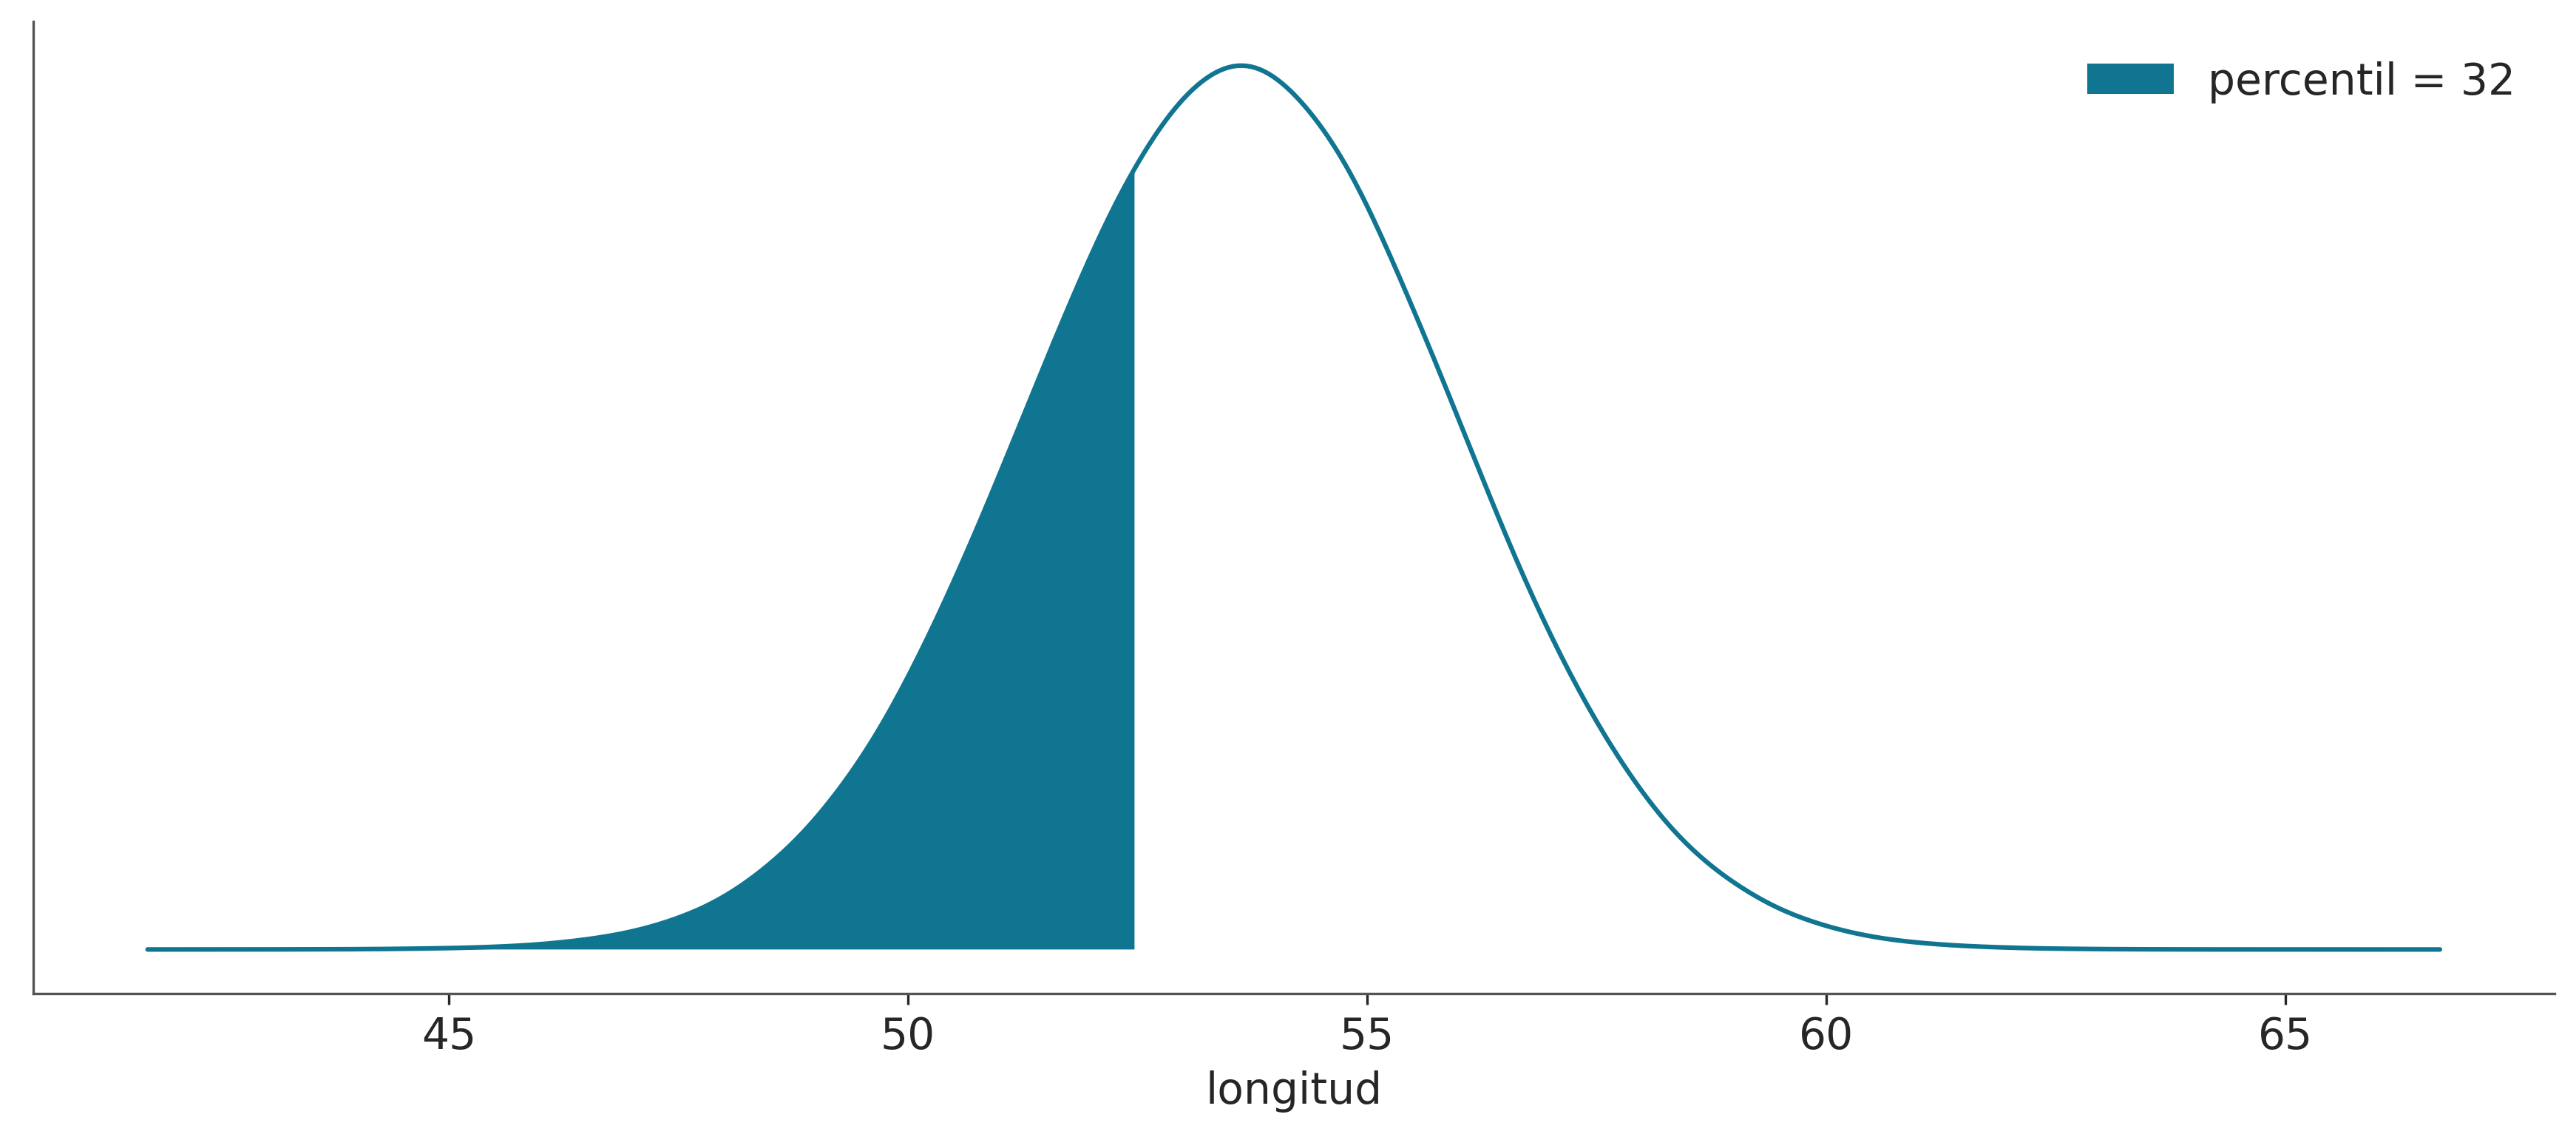

In [10]:
ref = 52.5
grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)
plt.plot(grid, pdf)
percentile = int((y_ppc <= ref).mean() * 100)
plt.fill_between(grid[grid < ref], pdf[grid < ref], label='percentil = {:2d}'.format(percentile))
plt.xlabel('longitud')
plt.yticks([])
plt.legend();

## Modelos lineales generalizados

Un modelo lineal generalizado tiene la siguiente forma


$$Y = \phi(f(\alpha + X \beta), \theta)$$

La regresion lineal que vimos anteriormente es un caso especial. 


$$Y = \mathcal{N}(\mu=\alpha + X \beta), \sigma=\theta)$$

* $f$ es la función inversa de enlace y tiene como objetivo permitir que los valores del modelo lineal, en general en $[-\infty, \infty]$
queden restringidos a un rango adecuado para ser parámetros de $\phi$

## Regresión logística

* La regresión logística es la generalización de la regresión lineal para cuando la variable dependiente sigue una distribución Bernoulli (o Binomial con n=1).


$$
\theta = \text{logística}(\alpha + X\beta) \\
Y = \text{Bern}(\theta) \tag{4.3} 
$$


* La función inversa de enlace es 

$$ \text{logística}(z) = \frac{1}{1 + e^{-z}} \tag{4.2}$$



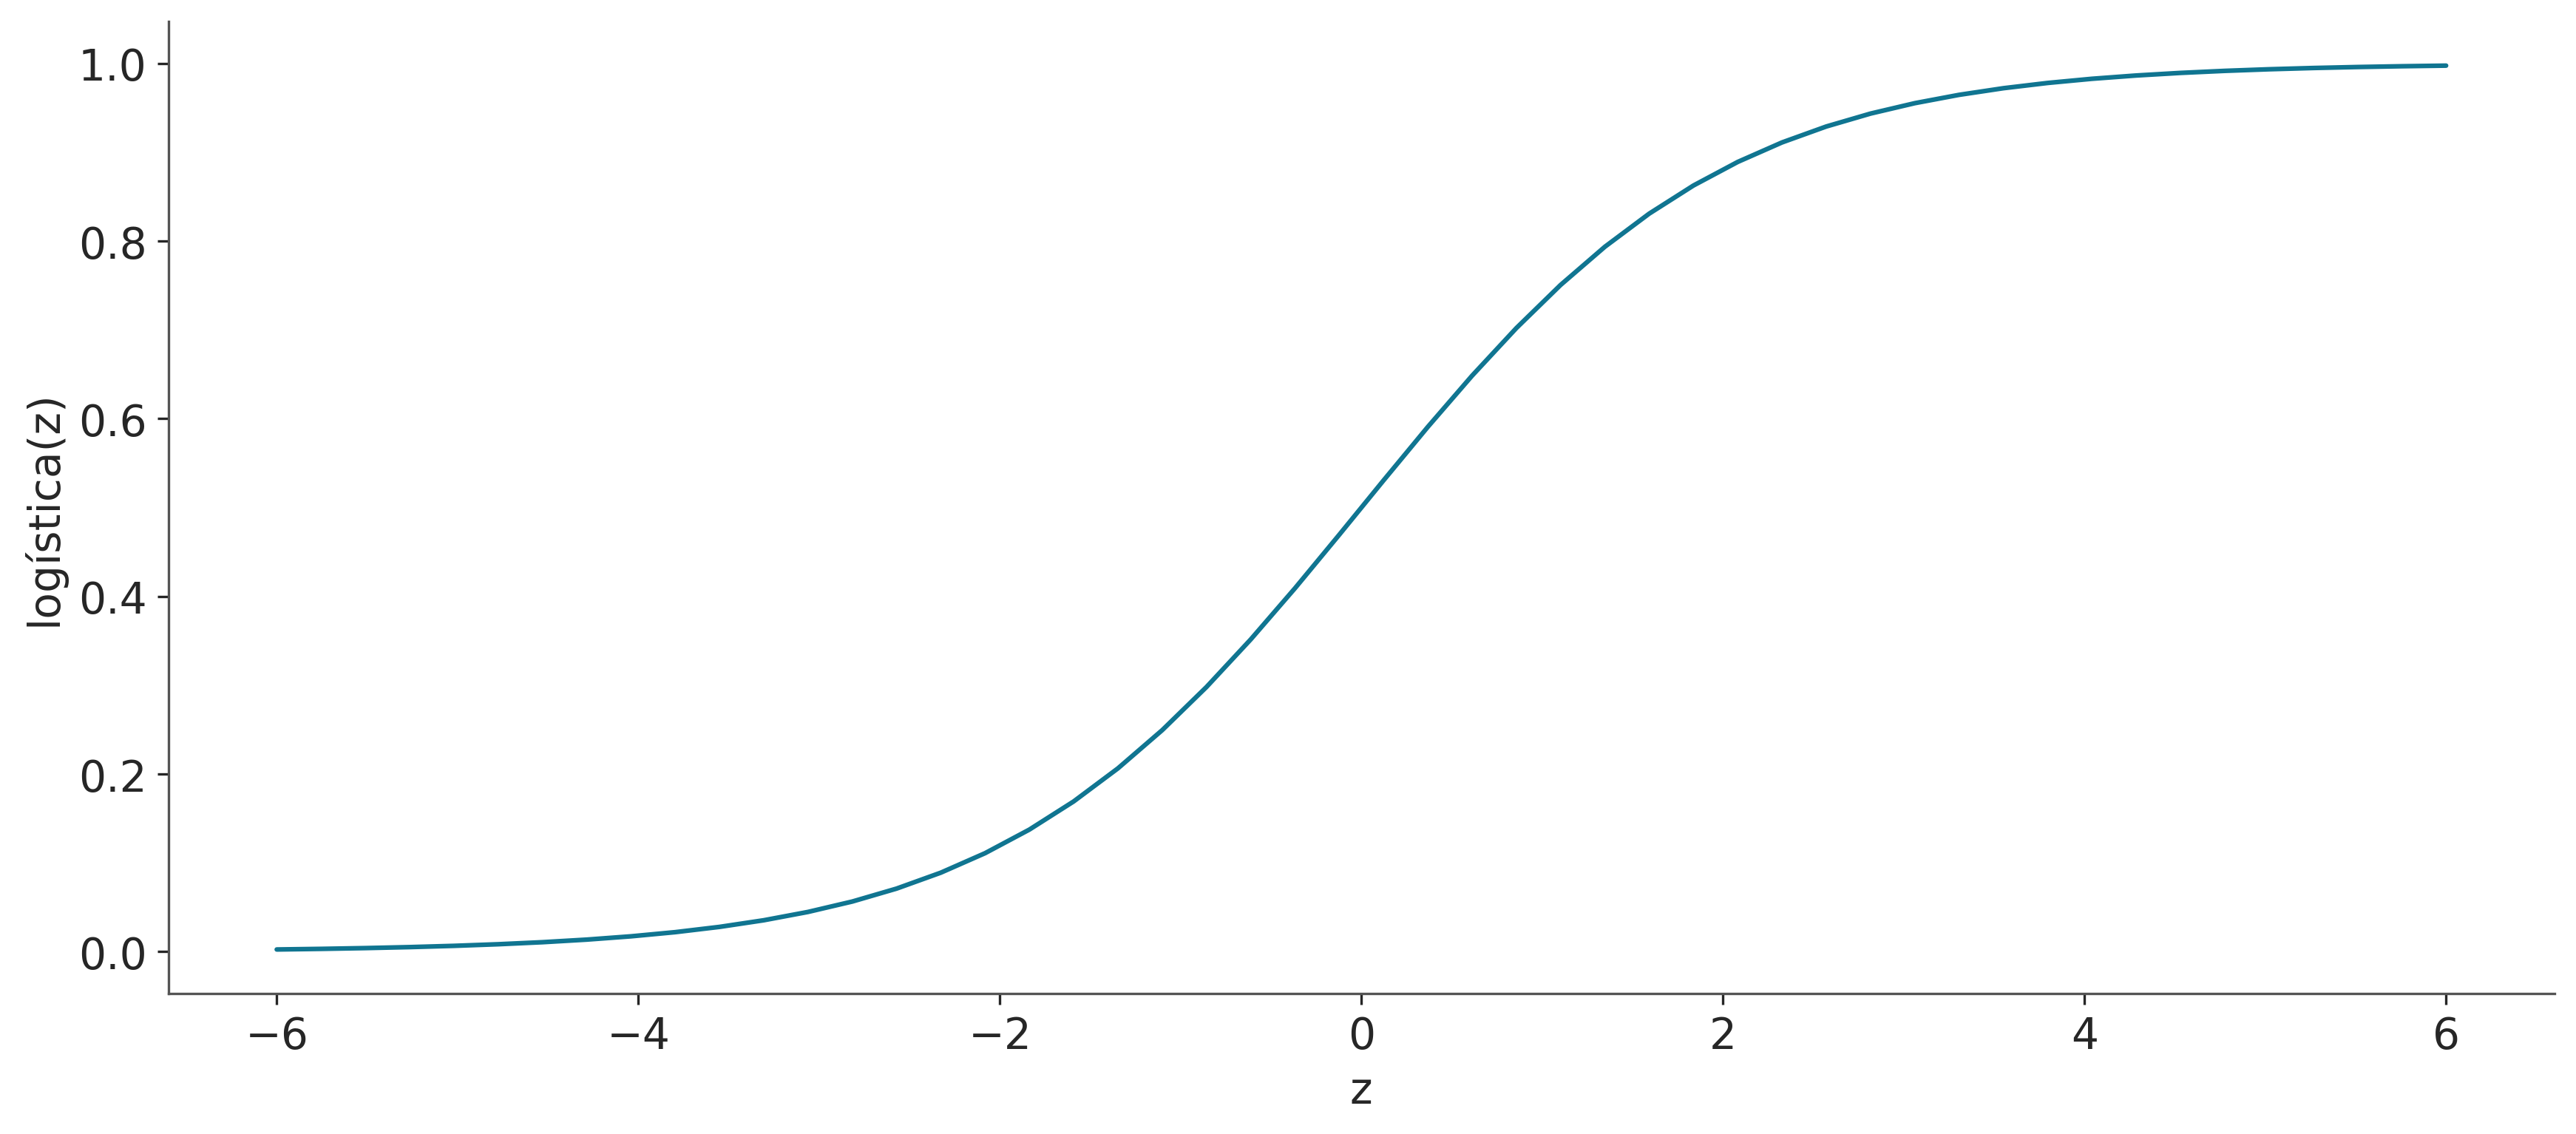

In [15]:
z = np.linspace(-6, 6)
logística = 1 / (1 + np.exp(-z))
plt.plot(z, logística)
plt.xlabel('z')
plt.ylabel('logística(z)');

## El conjunto de datos Iris


<br>


* Conjunto de datos clásico que contiene información sobre flores de 3 especies estrechamente relacionadas: setosa, virginica y versicolor. Estas serán nuestras variables dependientes. 


* Tenemos 50 individuos de cada especie 


* Para cada individuo contamos con cuatro variables (o _features_) que vamos a usar como variables independientes. El largo del pétalo, el ancho del pétalo, el largo del sépalo y el ancho del sépalo.

In [16]:
iris = pd.read_csv('../datos/iris.csv')
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

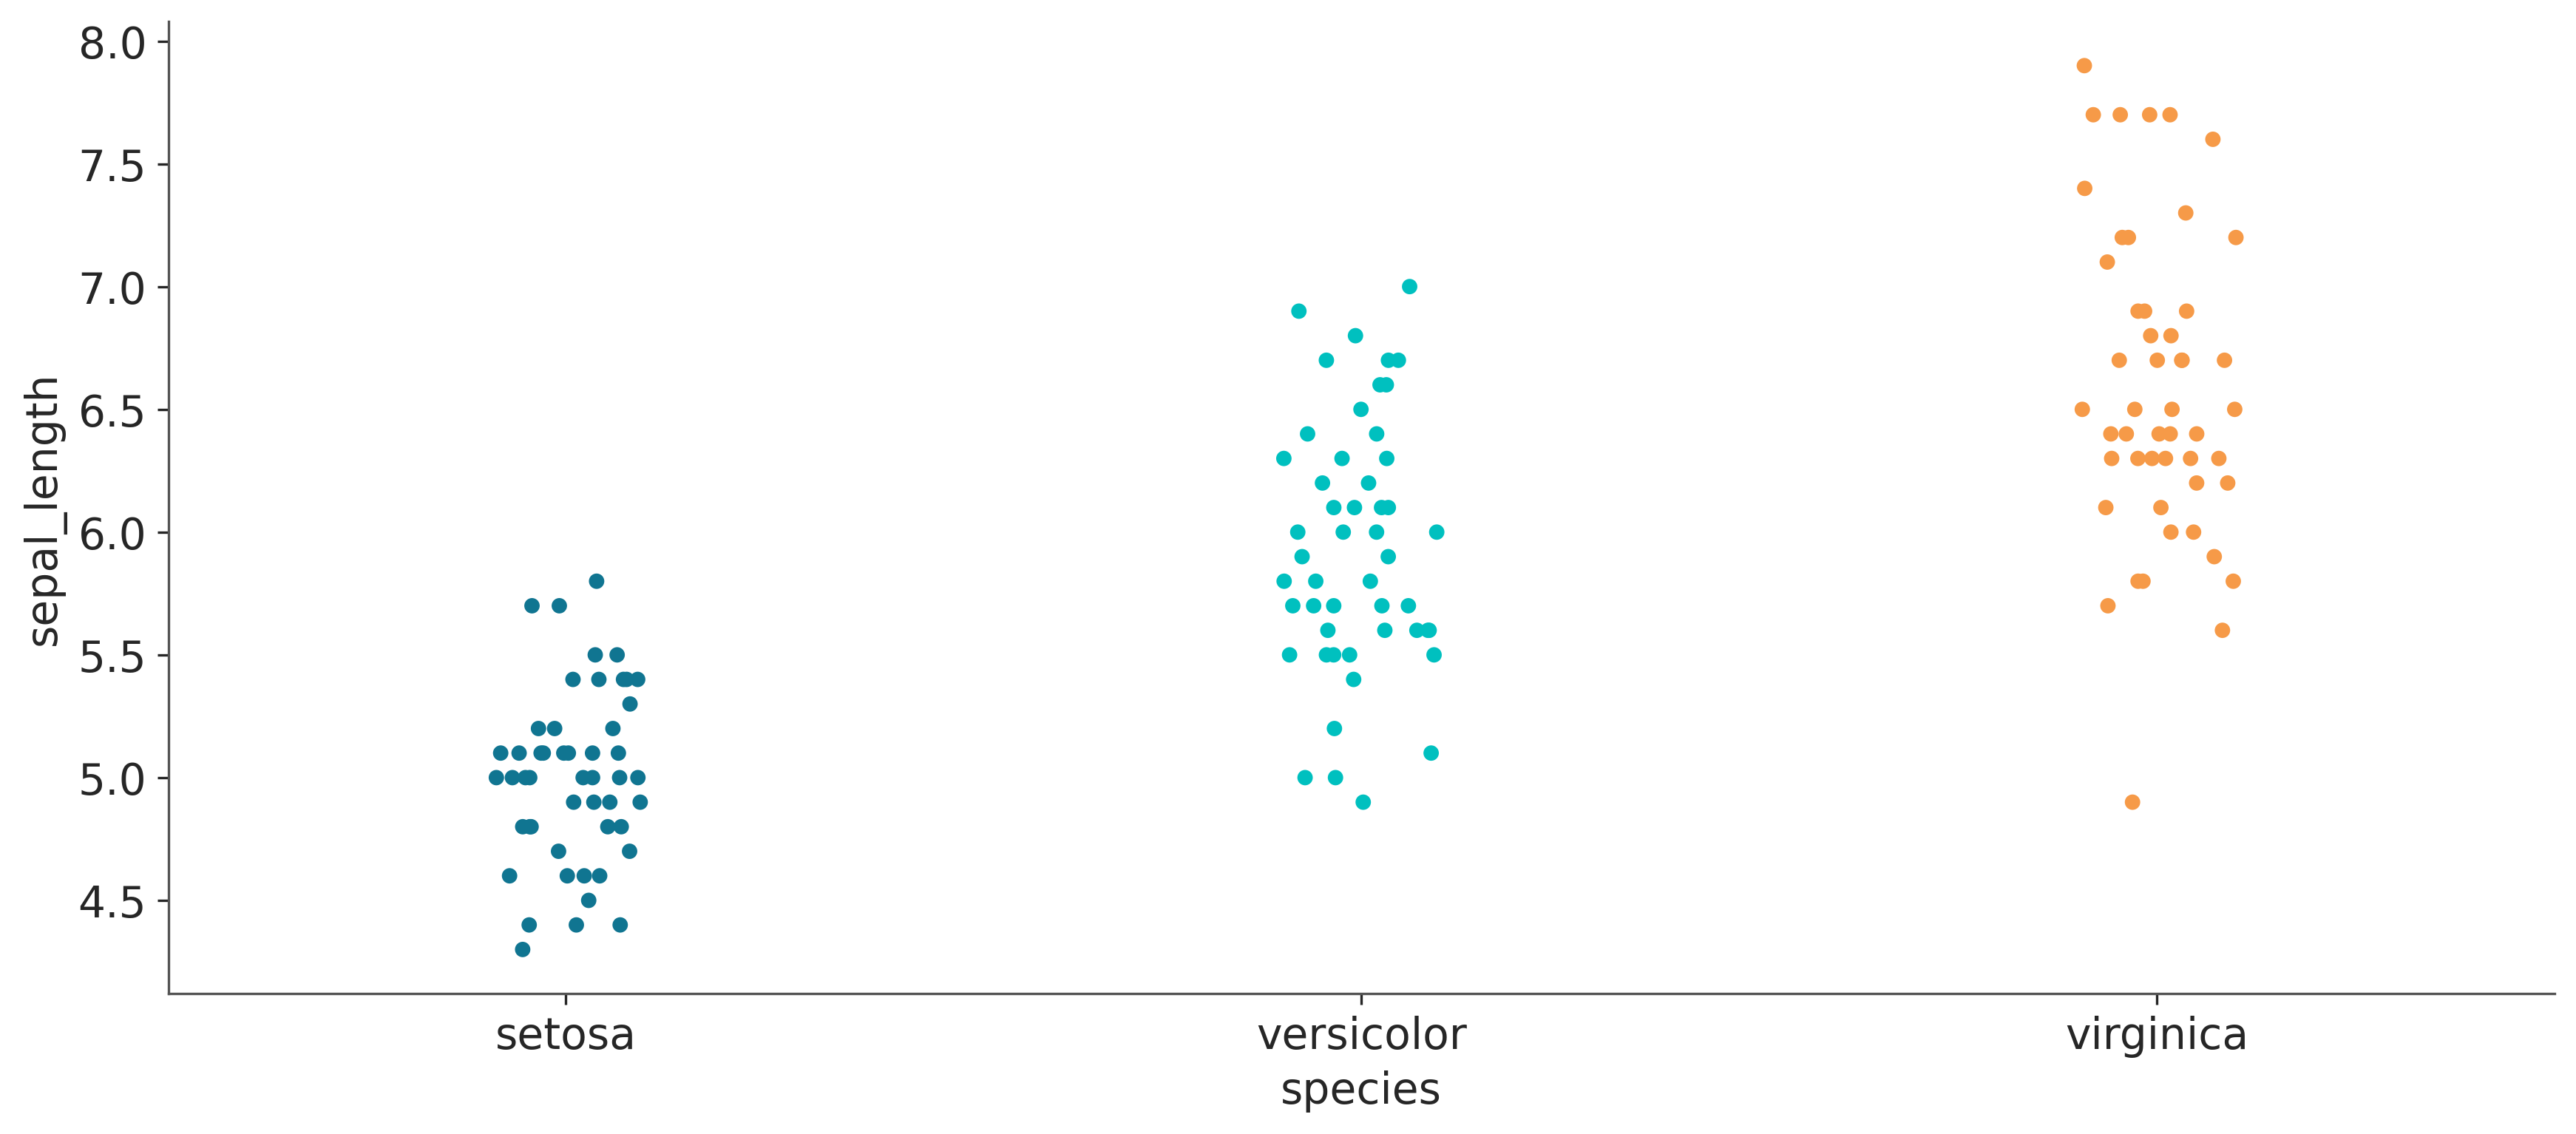

In [17]:
sns.stripplot(x="species", y="sepal_length", data=iris, hue="species", jitter=True, legend=False);

/home/osvaldo/anaconda3/envs/mol_bayes/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


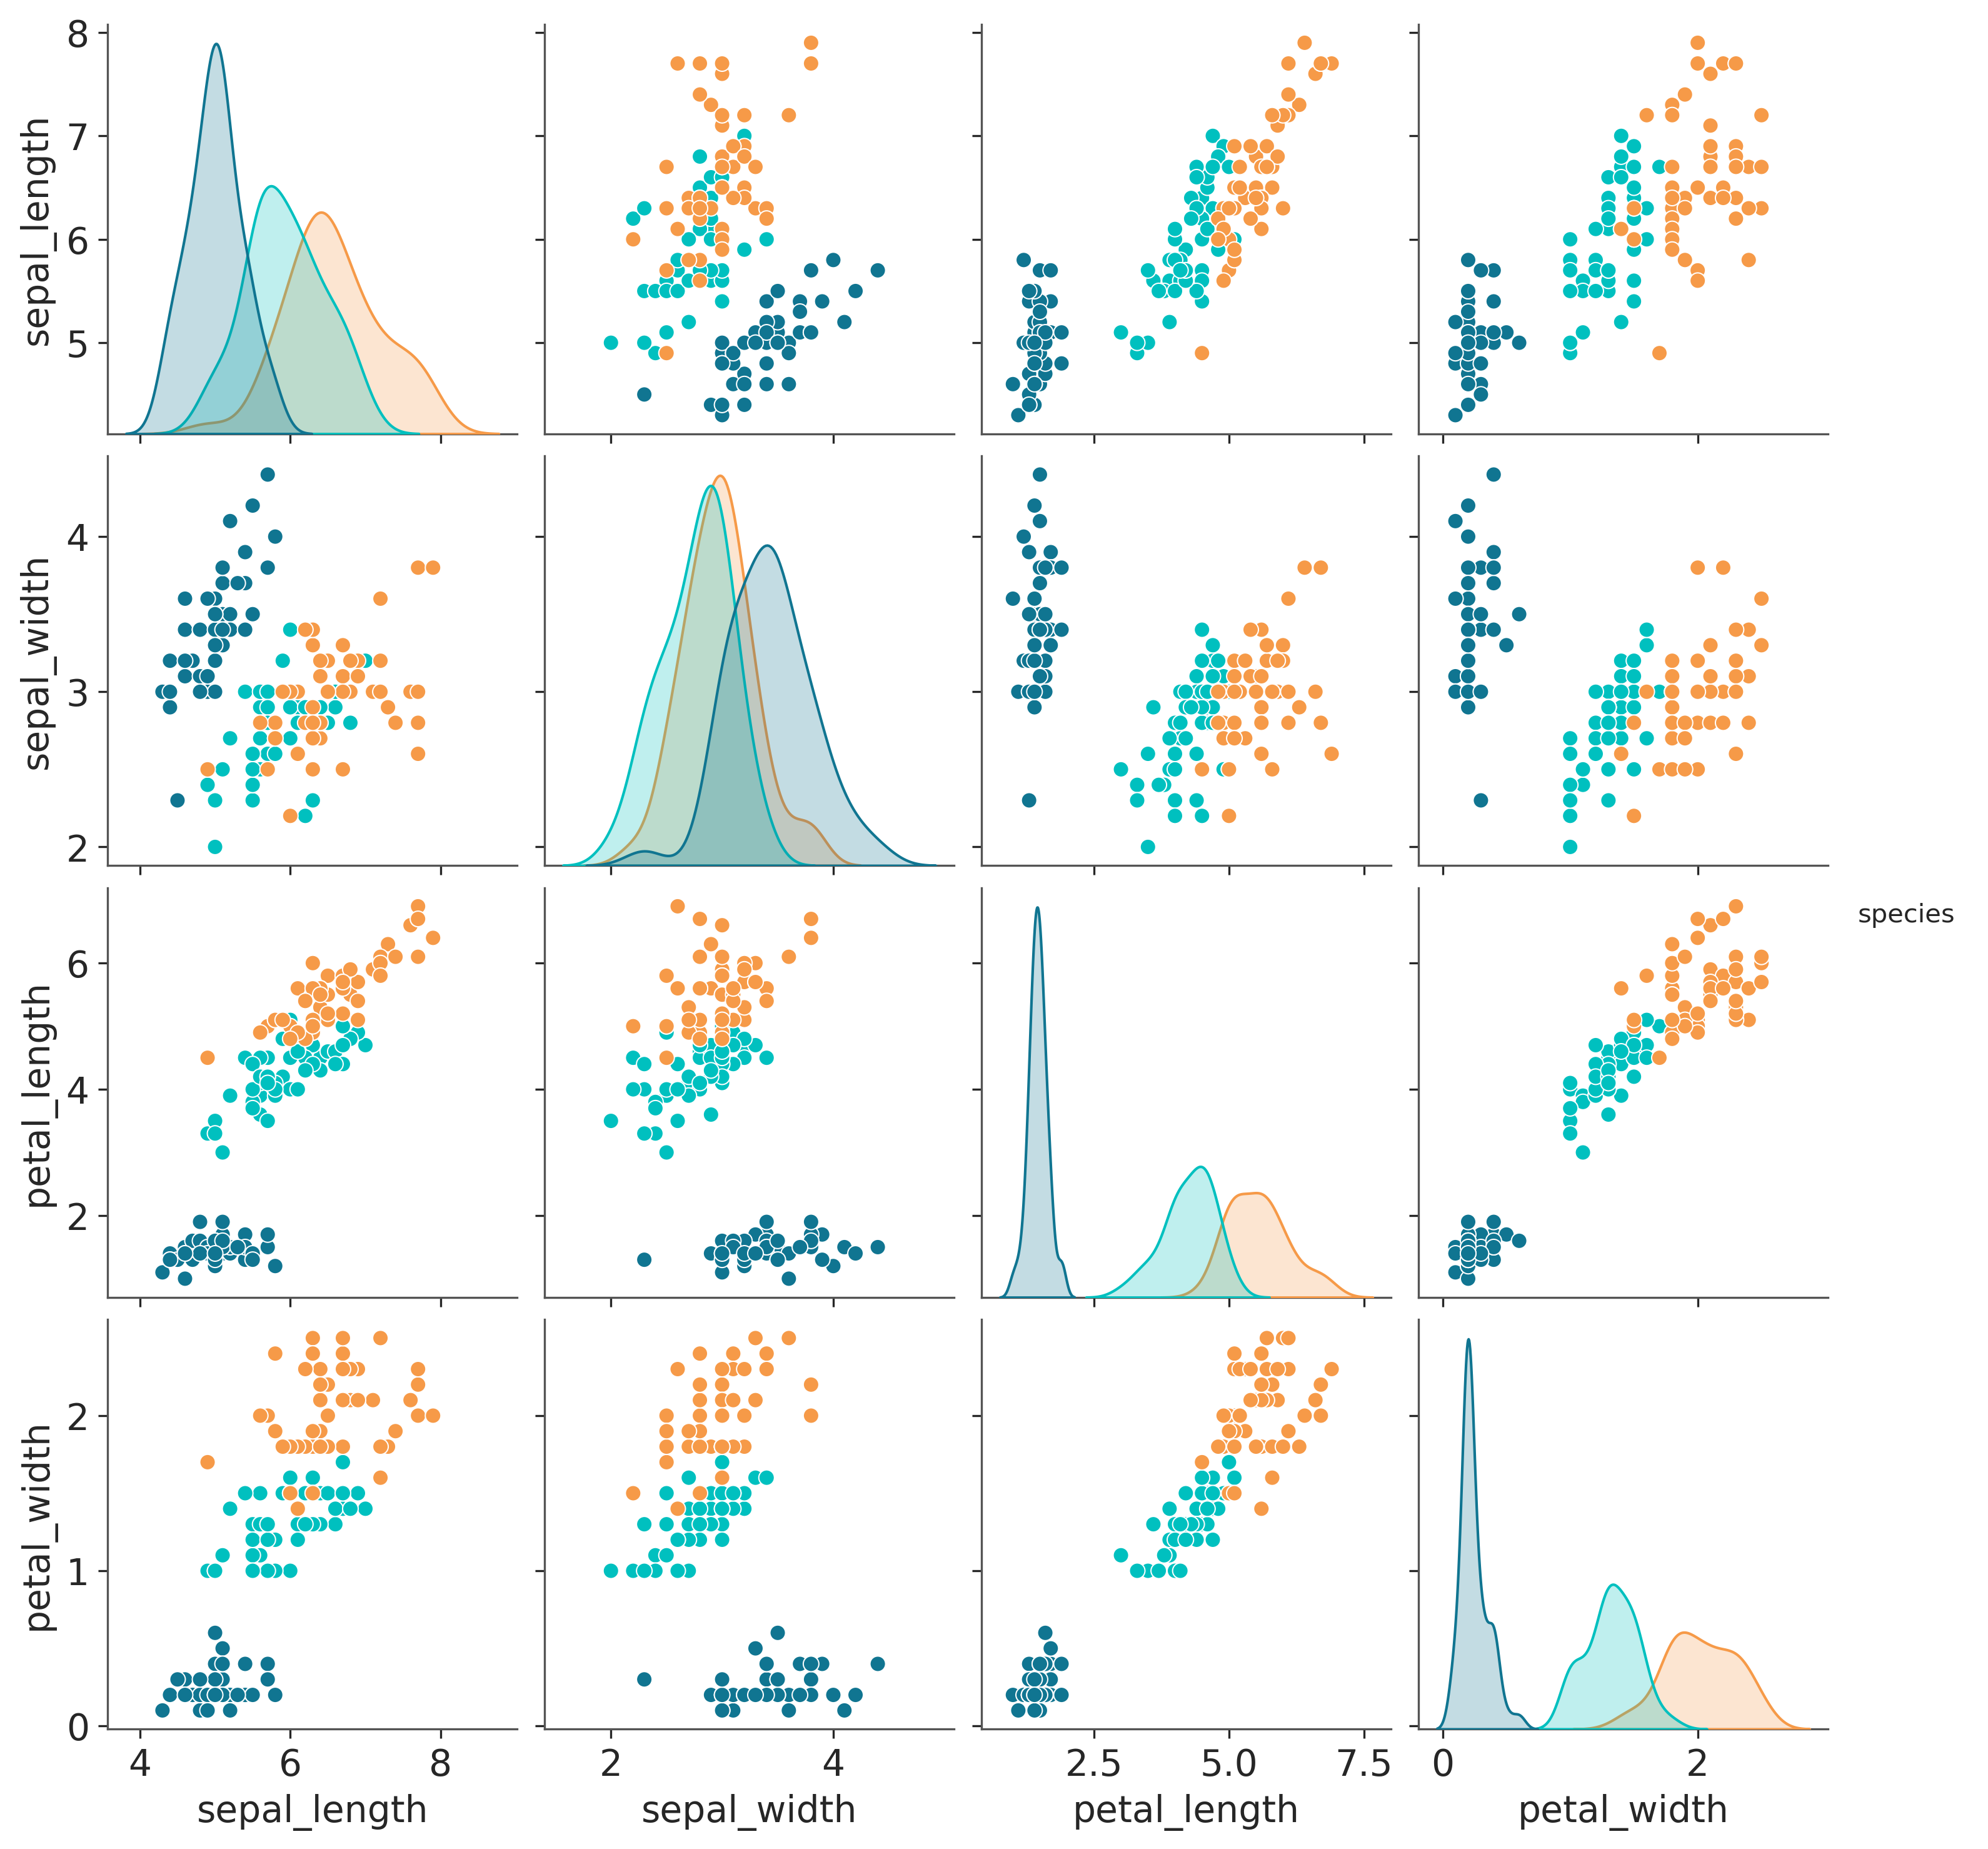

In [18]:
sns.pairplot(iris, hue='species', plot_kws={"legend":False});

In [19]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [20]:
with pm.Model() as modelo_0:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    idata_0 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


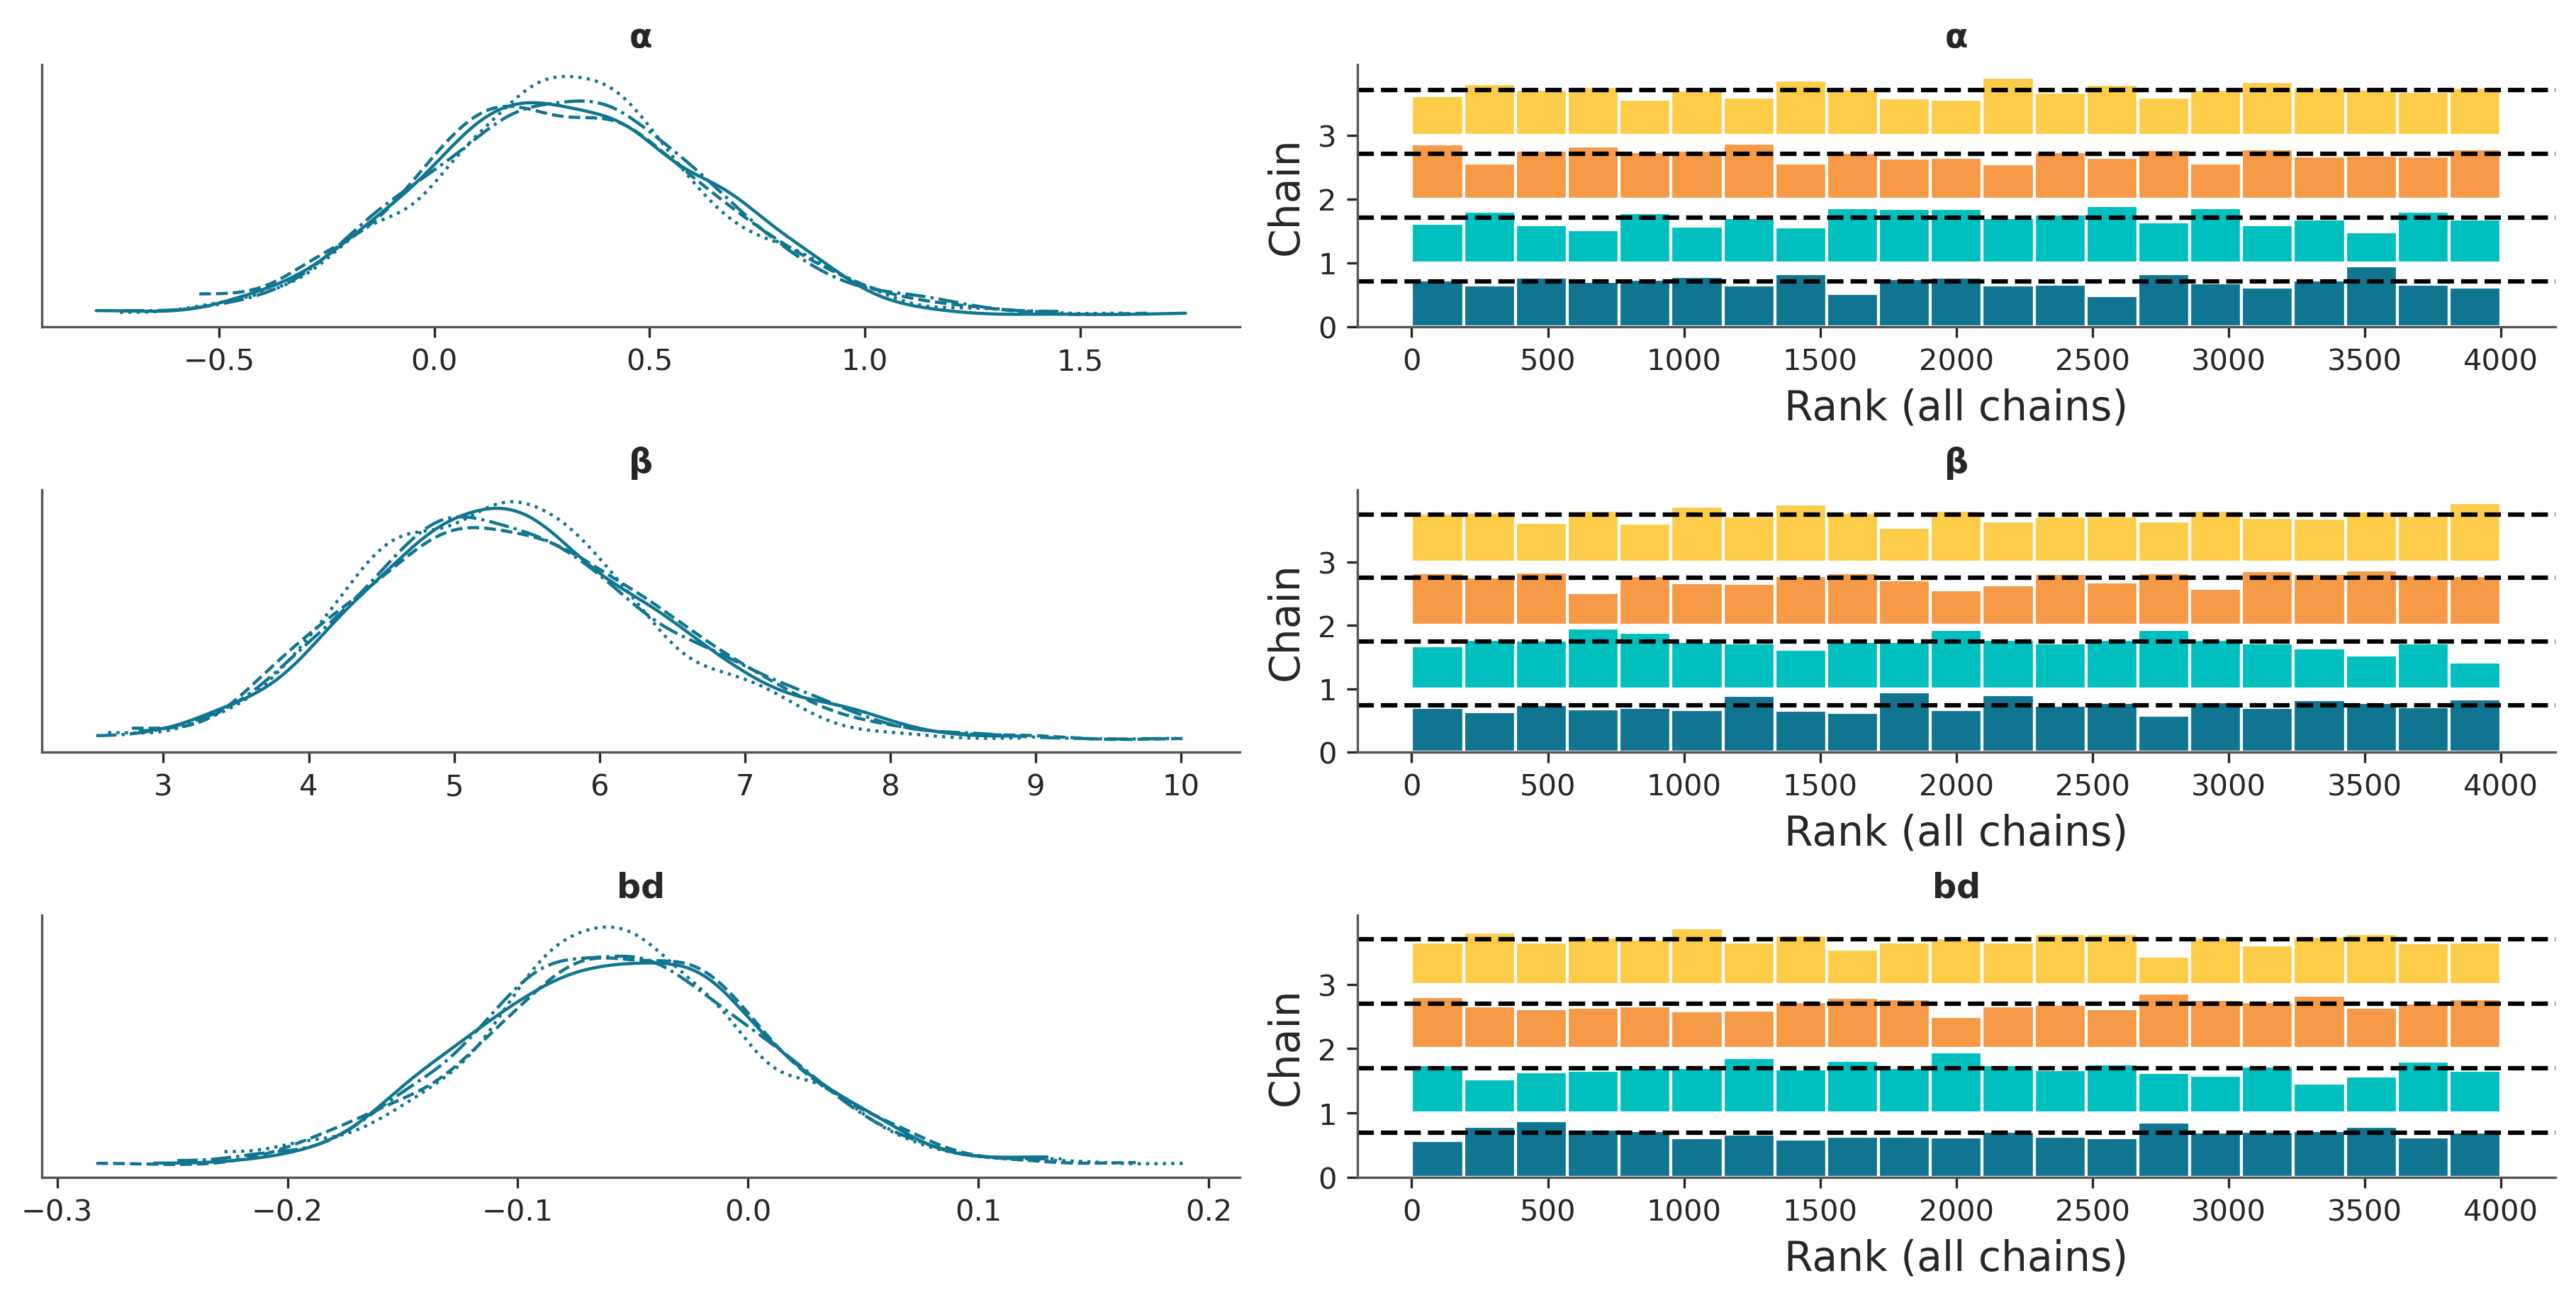

In [21]:
az.plot_trace(idata_0, var_names='~θ', kind="rank_bars");

In [22]:
az.summary(idata_0, var_names='~θ')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   0.306  0.335  -0.306    0.932      0.006    0.005    3225.0    2648.0   
β   5.415  1.031   3.592    7.389      0.020    0.015    2814.0    2092.0   
bd -0.056  0.062  -0.168    0.063      0.001    0.001    3315.0    2903.0   

    r_hat  
α     1.0  
β     1.0  
bd    1.0

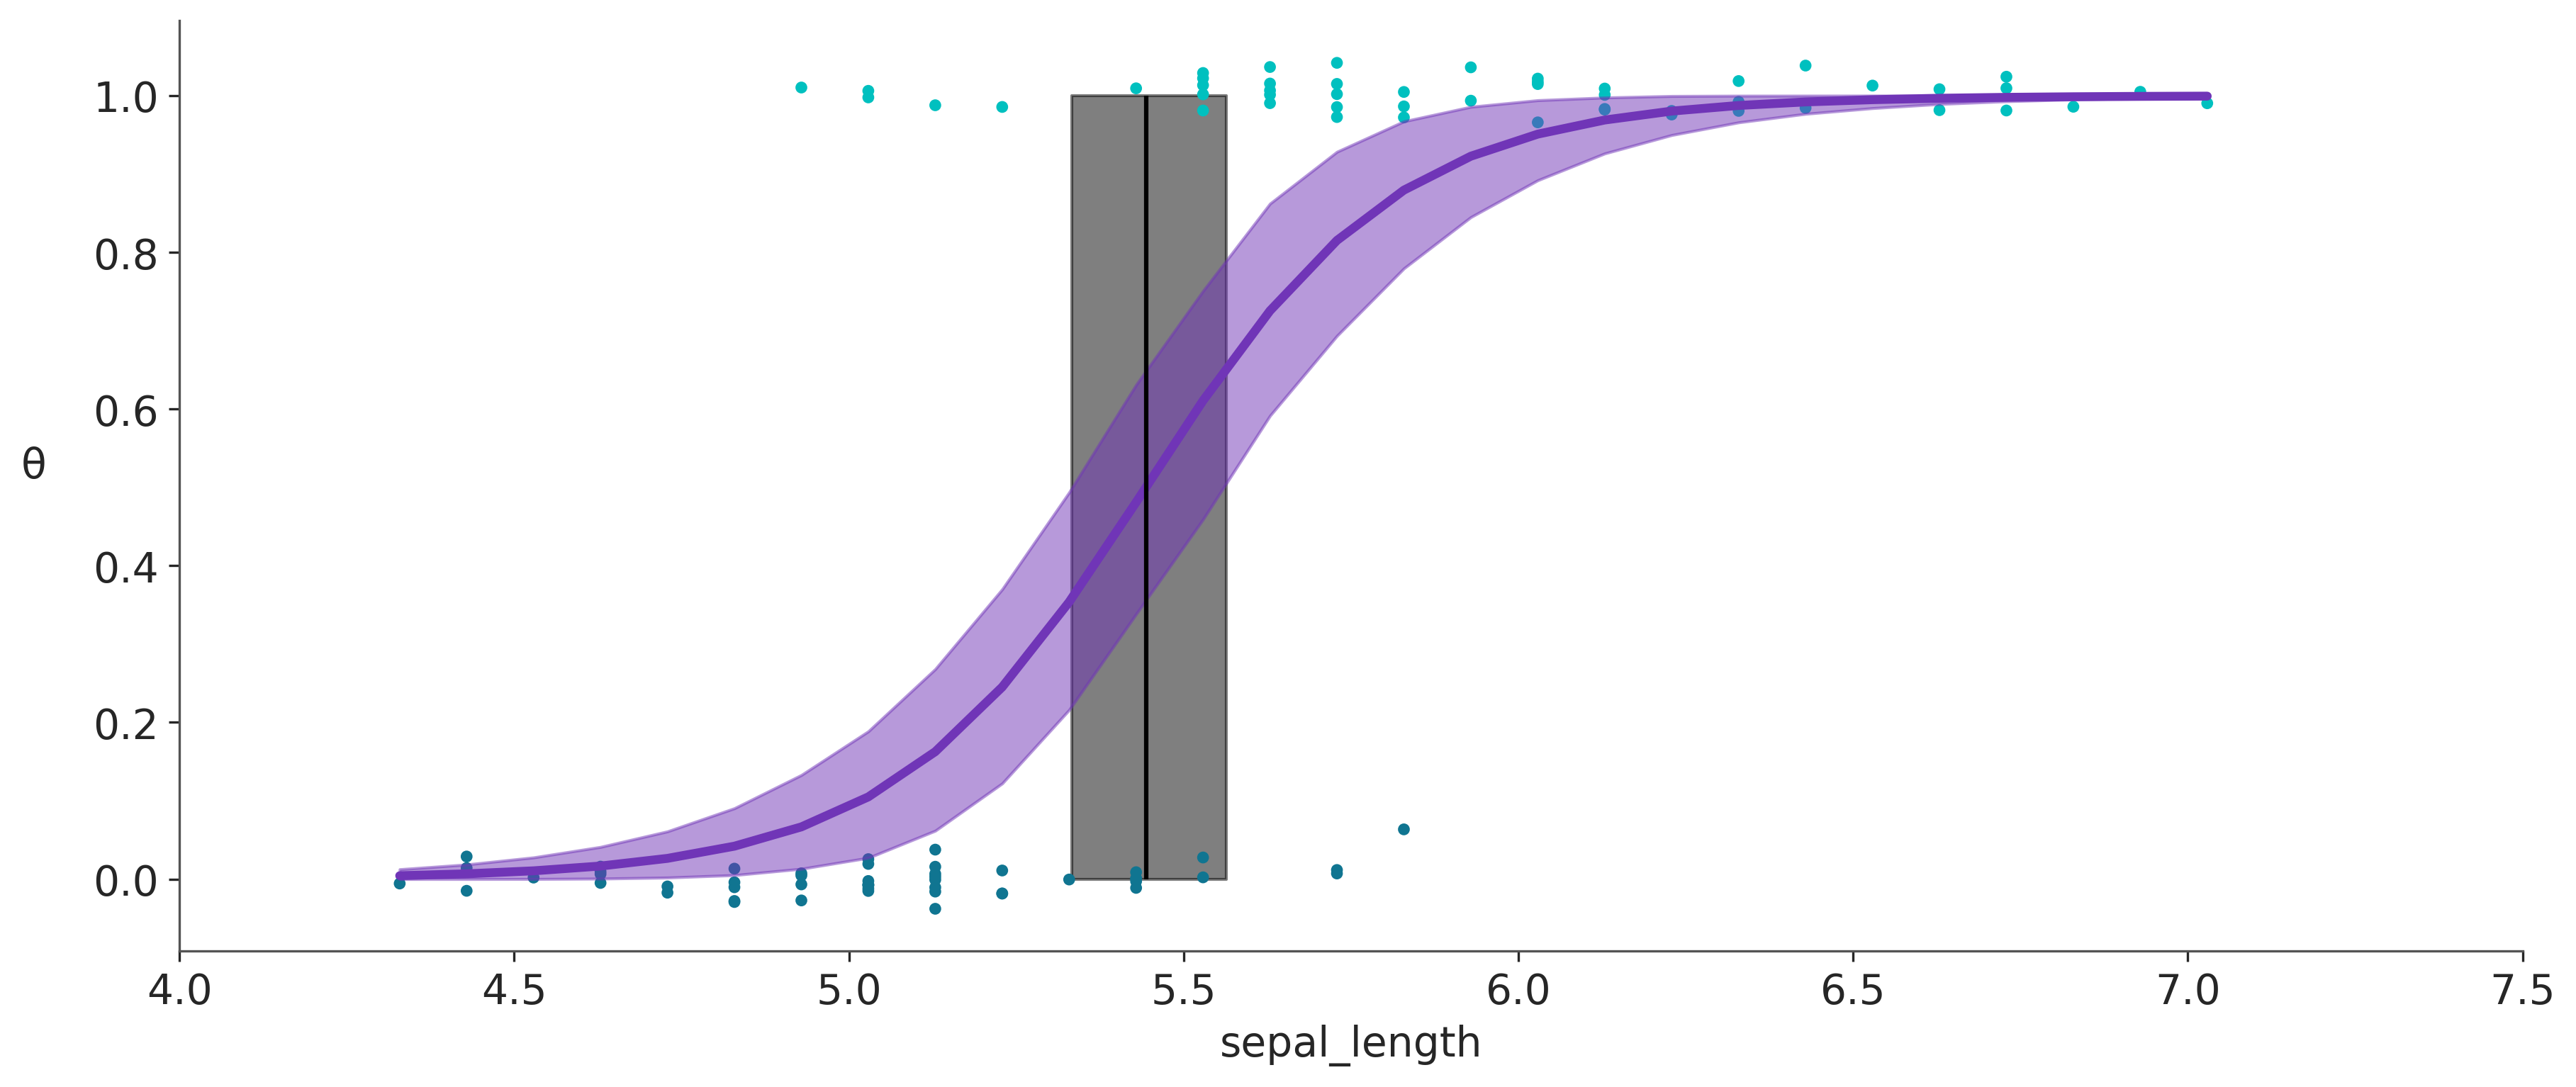

In [23]:
_, ax = plt.subplots(figsize=(12, 5))

post_0 = az.extract(idata_0)

theta = post_0['θ'].mean("sample")
idx = np.argsort(x_c)
ax.plot(x_c[idx], theta[idx], color='C8', lw=3)
ax.vlines(post_0['bd'].mean("sample"), 0, 1, color='k')
bd_hdi = az.hdi(post_0.unstack())["bd"]
ax.fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='k', alpha=0.5)

ax.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
theta_hdi = az.hdi(post_0.unstack())['θ'][idx]
ax.fill_between(x_c[idx], theta_hdi[:,0], theta_hdi[:,1], color='C8', alpha=0.5)

ax.set_xlabel(x_n)
ax.set_ylabel('θ', rotation=0, labelpad=20)
# use original scale for xticks
locs, _ = plt.xticks() 
ax.set_xticks(locs, np.round(locs + x_0.mean(), 1));

Resumiendo los puntos más importantes hasta el momento:

* El valor de $\theta$ se corresponden con $p(y= 1 \mid x) $. En este sentido, la regresión logística es una regresión.

* Si queremos clasificar tenemos que agregar una regla para convertir esta probabilidad en una asignación de dos clases. En este caso, si $p(y = 1) >= 0.5 $ asignamos clase 1, de lo contrario clase 0.

* No hay nada especial en el valor 0.5, aparte de ser el número a mitad de camino entre 0 y 1. 

# Regresión logística múltiple

<br>

De manera similar a la regresión lineal múltiple, la regresión logística múltiple consiste en utilizar más de una variable independiente. 



In [24]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width']
#x_n = ['petal_length', 'petal_width']
x_1 = df[x_n].values

In [25]:
with pm.Model() as modelo_1: 
    α = pm.Normal('α', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    idata_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


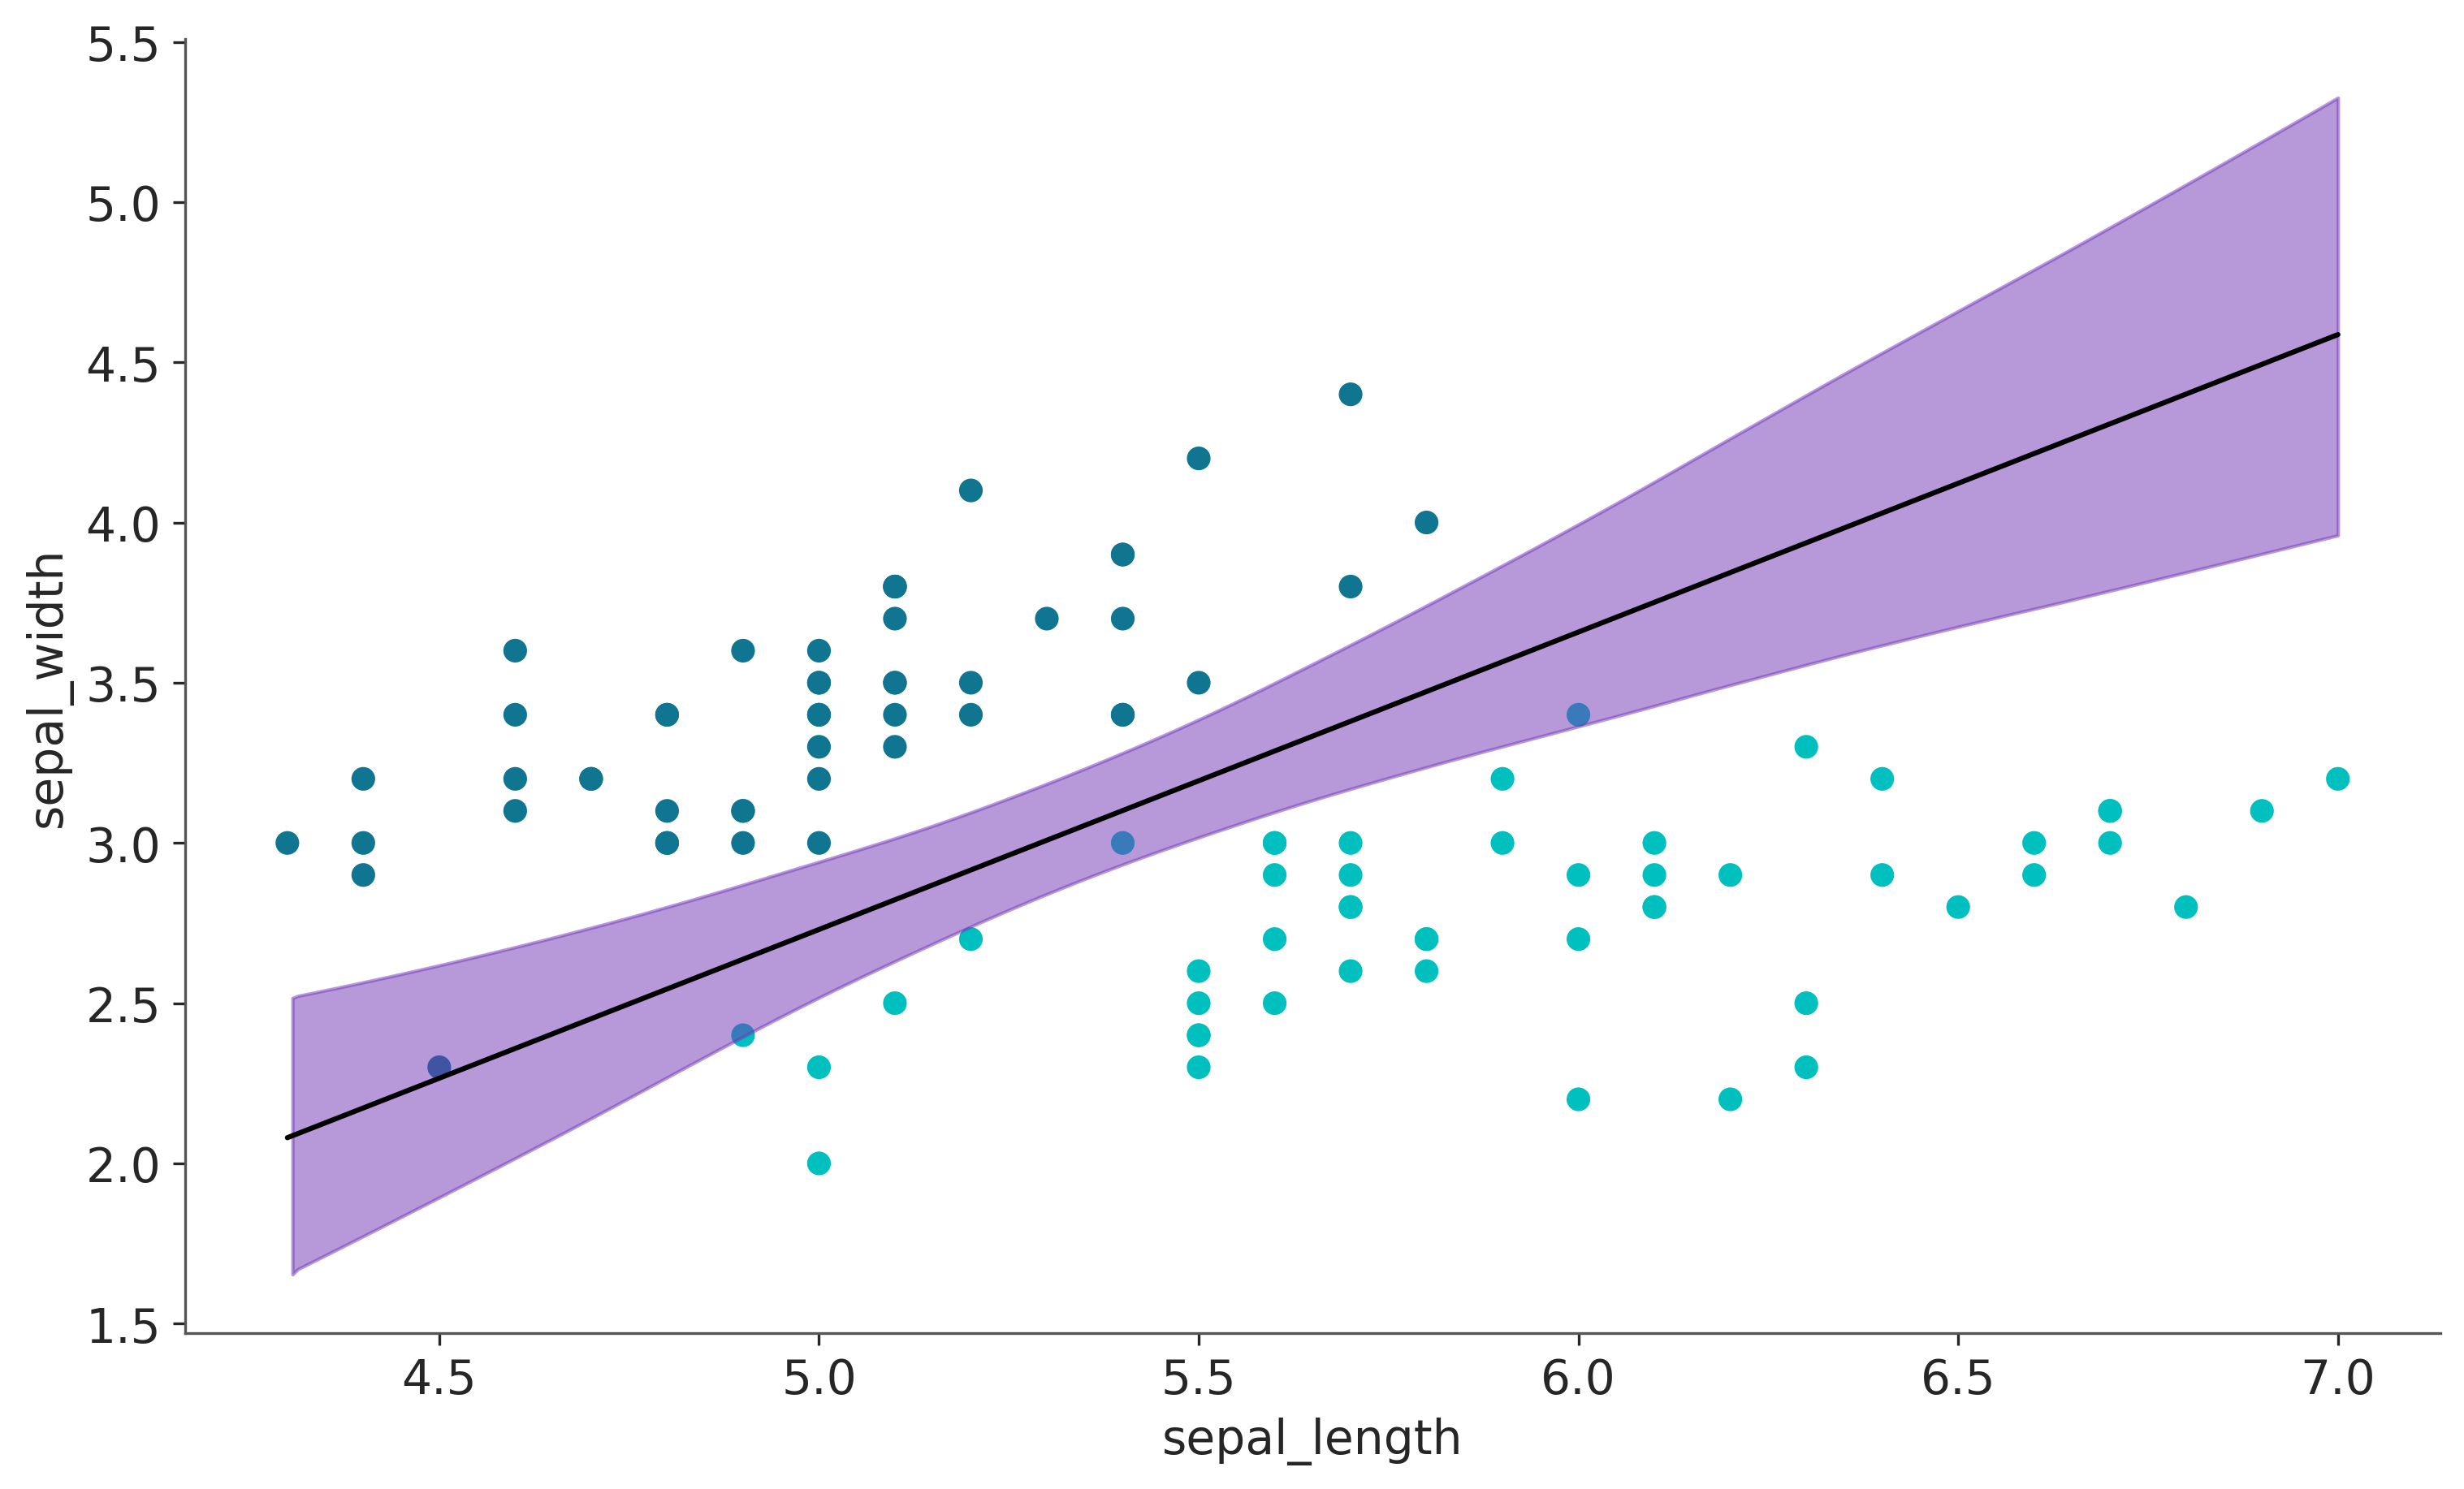

In [26]:
_, ax = plt.subplots(figsize=(10, 6))

idx = np.argsort(x_1[:,0]) 

bd = idata_1.posterior['bd'].mean(("chain", "draw"))[idx] 
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_1[:,0][idx], bd, color='k'); 
 
az.plot_hdi(x_1[:,0], idata_1.posterior['bd'], color="C8")
    
ax.set_xlabel(x_n[0]) 
ax.set_ylabel(x_n[1]);

## Regresión de Poisson


* Un escenario común es el de contar cosas. La descomposición de un núcleo radioactivo, el número de hijos por pareja o el número de seguidores de Twitter. 


* Para todos estos casos es común usar números discretos no negativos {0, 1, 2, 3 ...}


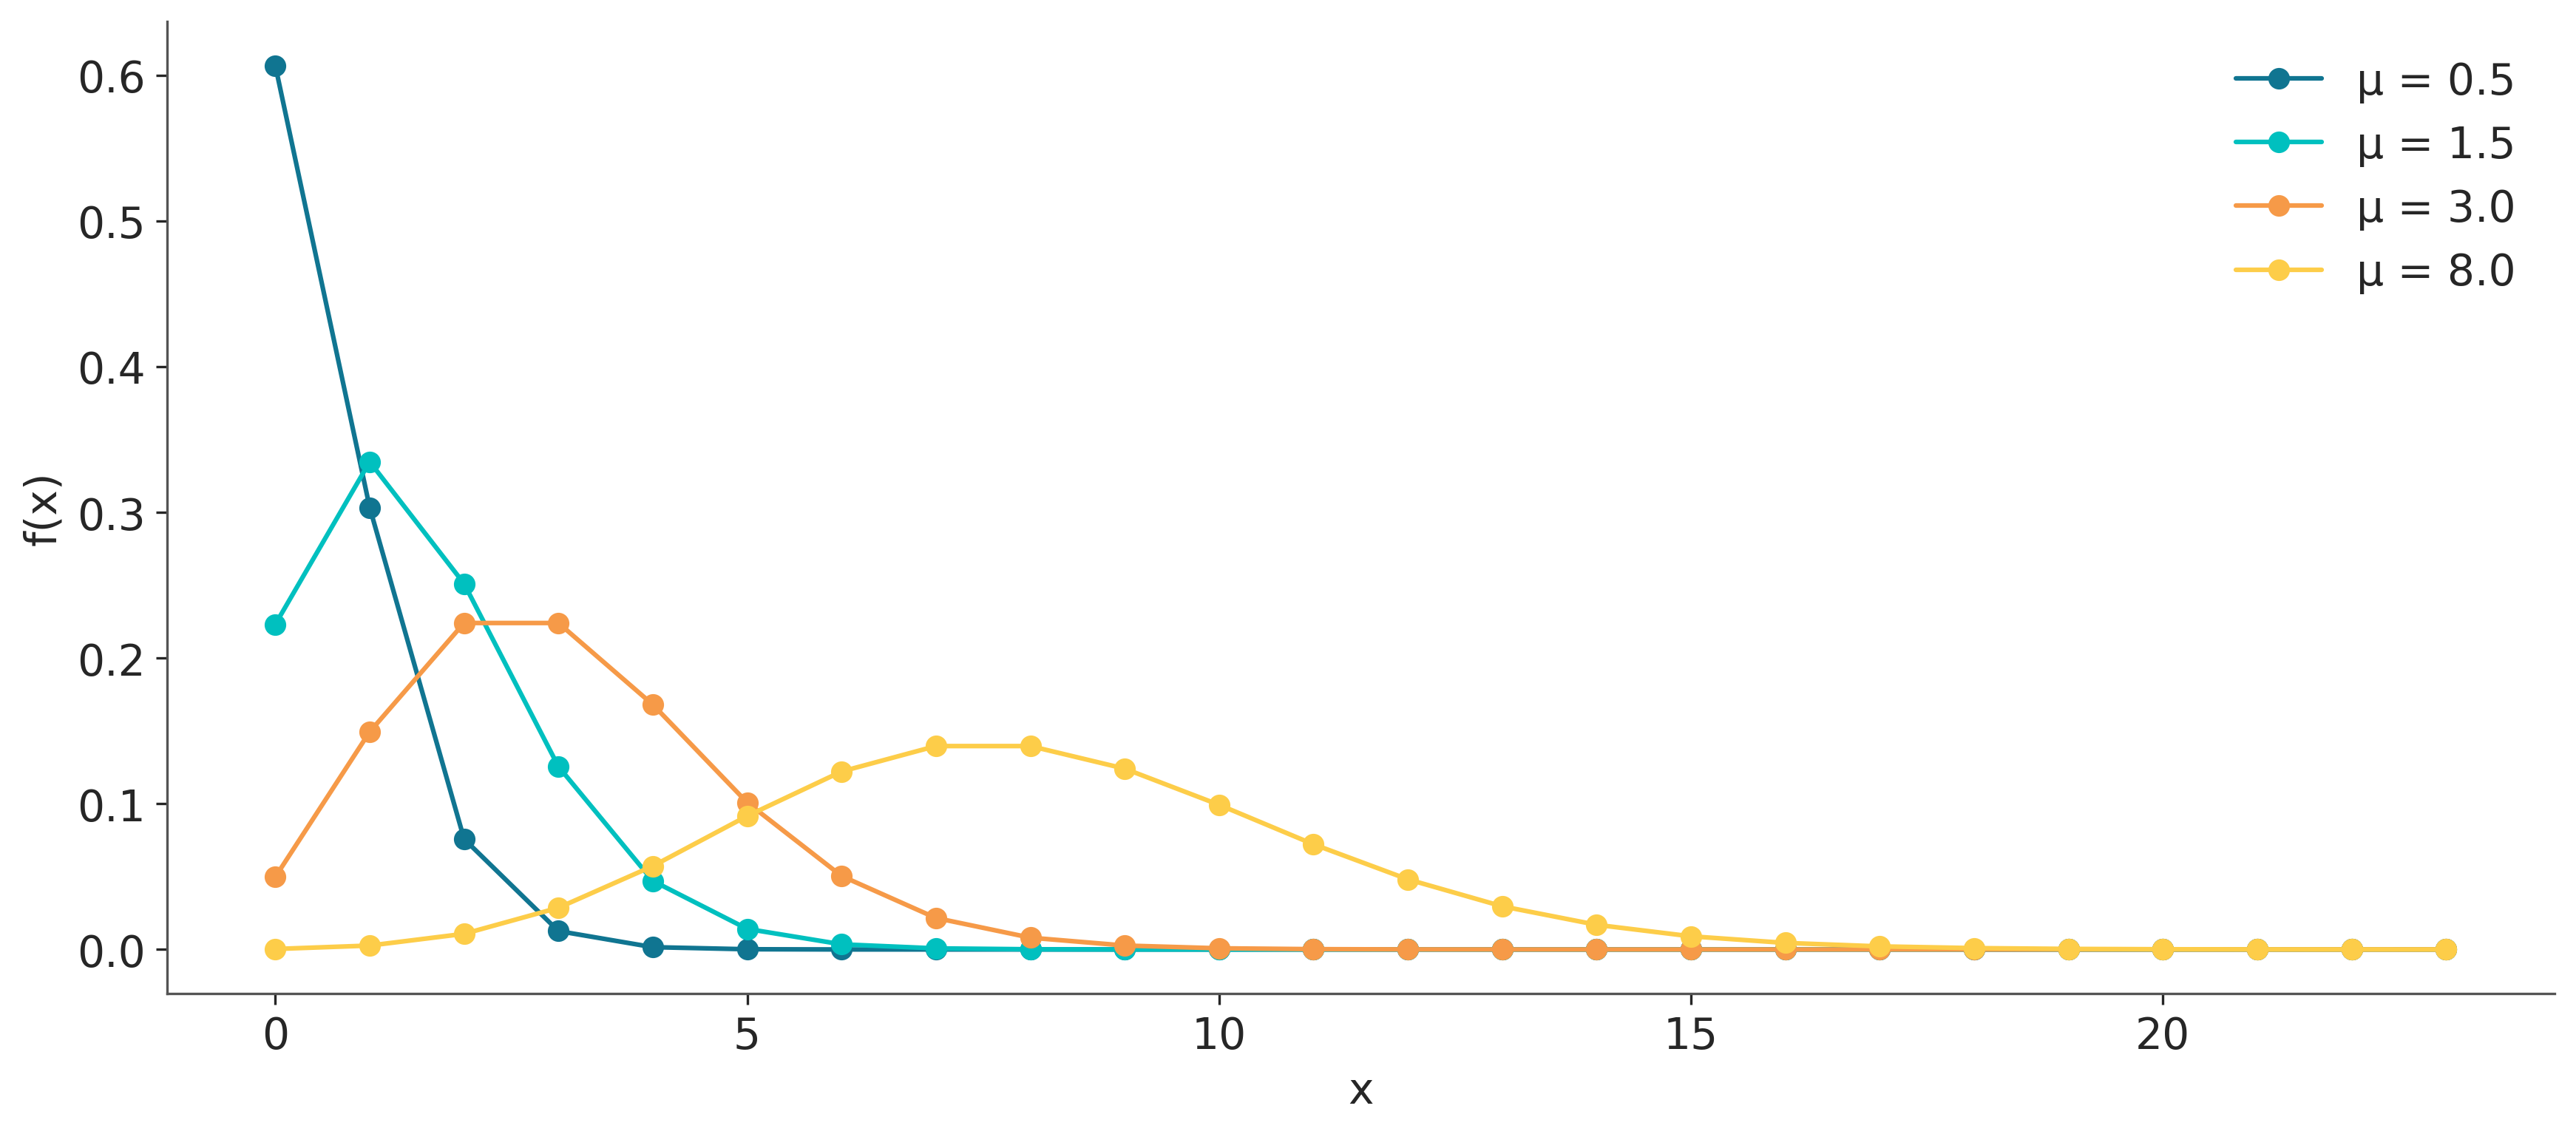

In [27]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = pz.Poisson(mu).rv_frozen.pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)');

## El modelo de Poisson inflado de ceros

* Al contar cosas, una posibilidad es no contar esas cosas, es decir obtener cero. 

* El número cero puede ocurrir por que efectivamente algo no sucedió o por que sucedió, pero no fuimos capaces de observarlo

* EL modelo Poisson inflado de ceros modela dos procesos
    * Una distribución de Poisson con probabilidad $\psi$
    * Ceros "extras" con probabilidad $1 - \psi$.

In [28]:
fish_data = pd.read_csv('../datos/fish.csv')

In [29]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 10, shape=2)
    θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
    idata_ZIP_reg = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ψ, α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


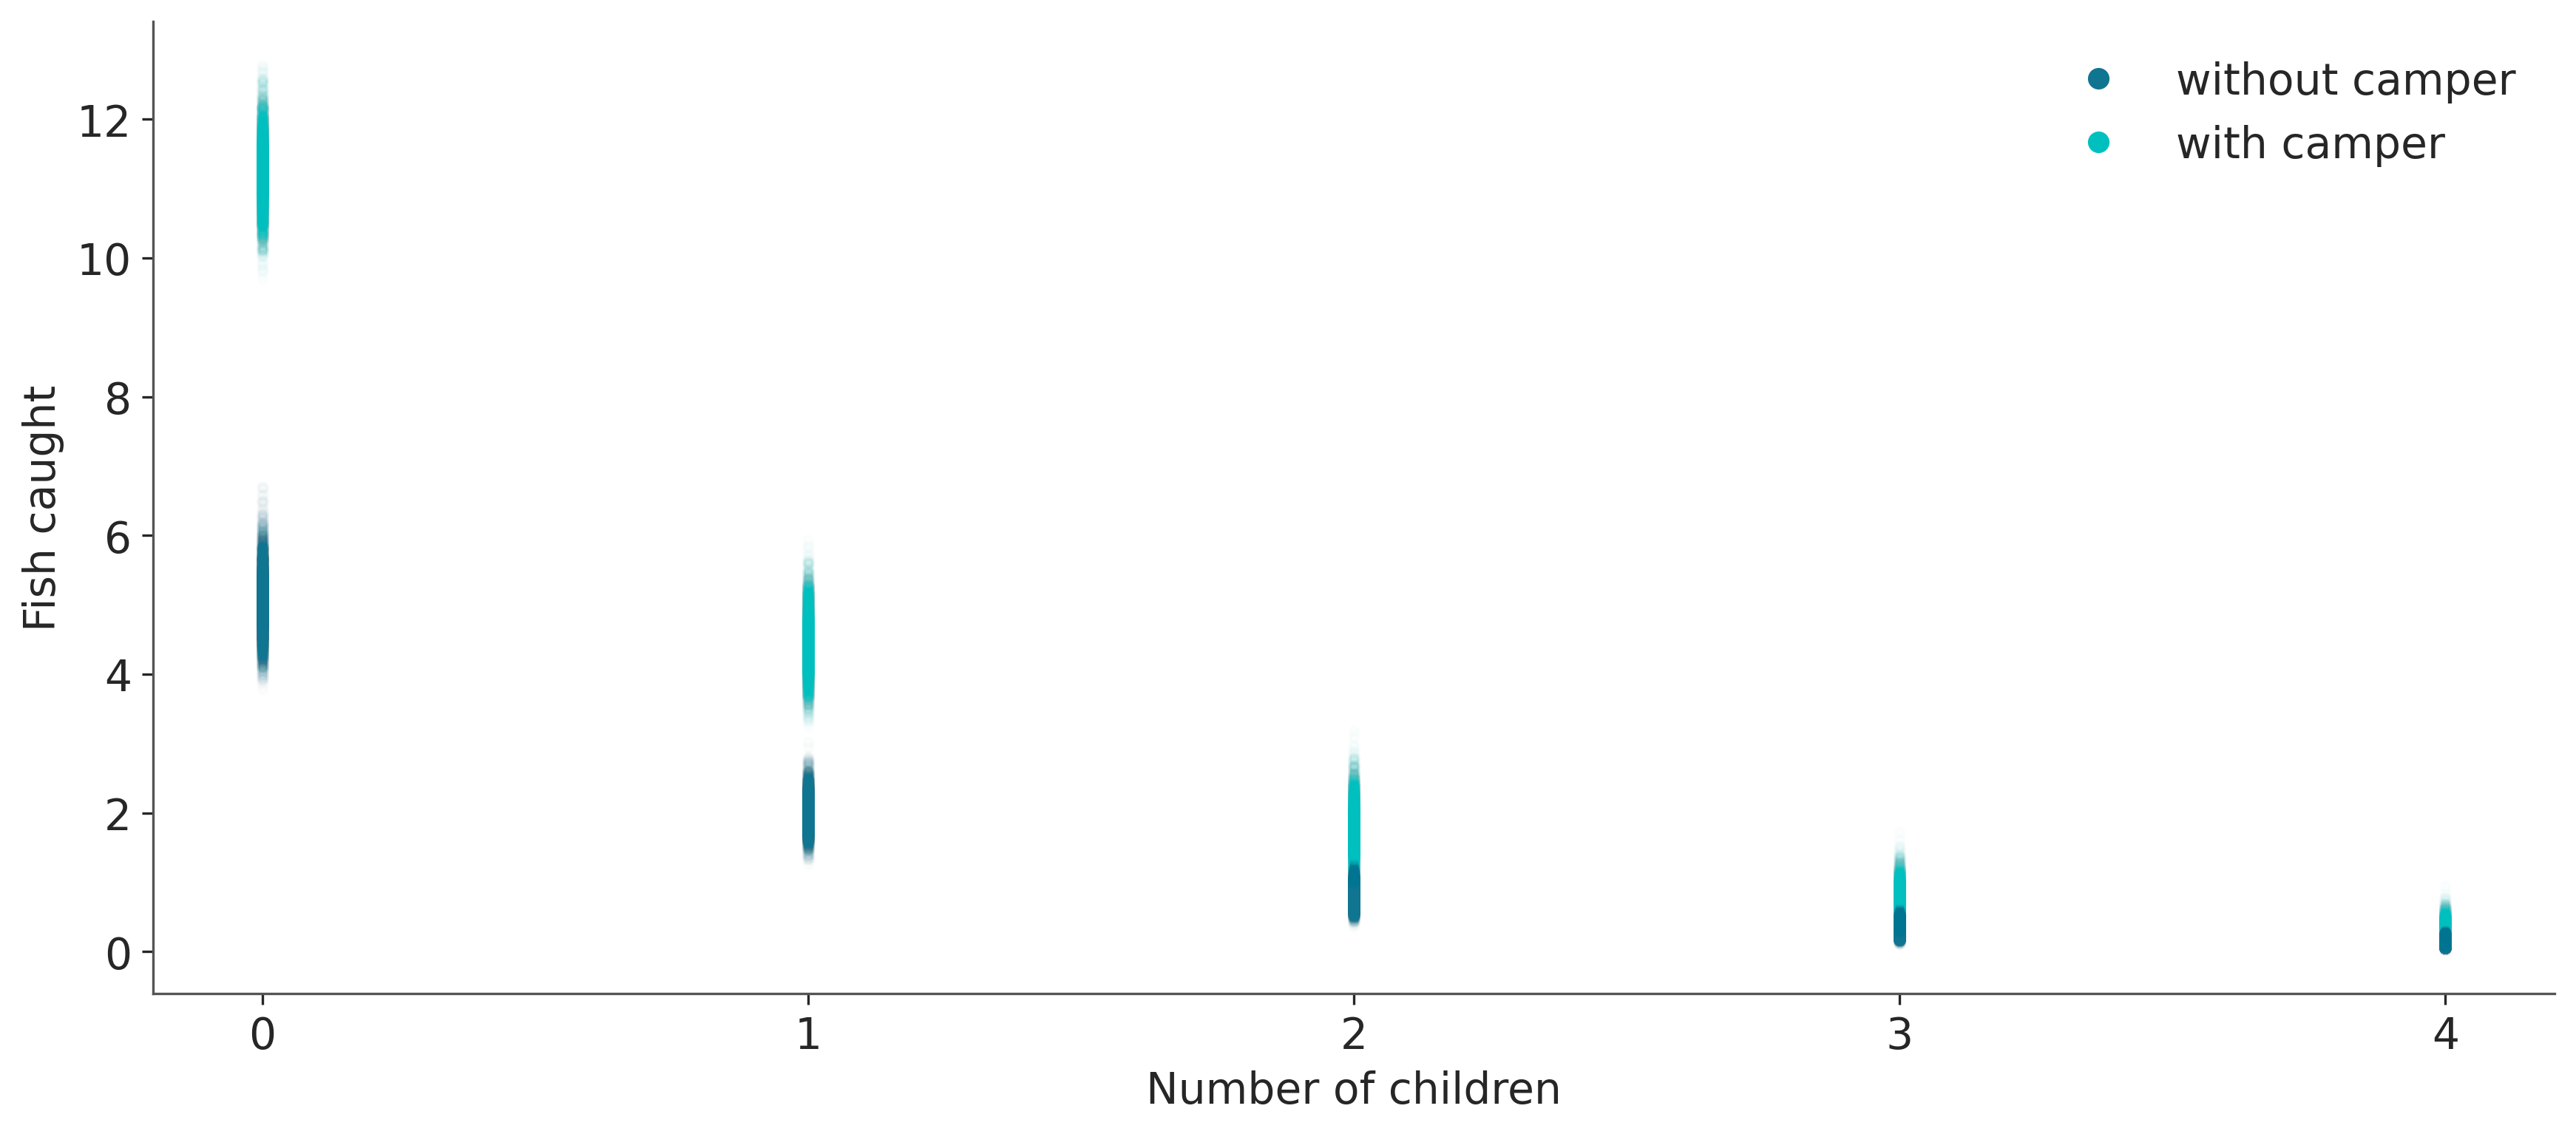

In [30]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []

post_ZIP_reg = az.extract(idata_ZIP_reg)

for n in children:
    without_camper = post_ZIP_reg['α'] + post_ZIP_reg['β'].sel({"β_dim_0":0}) * n
    with_camper = without_camper + post_ZIP_reg['β'].sel({"β_dim_0":1})
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))
plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

    
plt.xticks(children);
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend();